In [ ]:
!pip install sortedcontainers stable_baselines3 stable-baselines3[extra] shimmy gymnasium

In [ ]:
#
# Research-Grade Limit Order Book (LOB) Simulator and Test Suite
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import heapq
import collections
import time

# --- 2. Limit Order Book (LOB) Data Structure ---

class LimitOrderBook:
    """A class to represent a limit order book."""

    def __init__(self):
        # Bids are stored in descending price order, asks in ascending price order
        self.bids = SortedDict()  # {price: volume}
        self.asks = SortedDict()  # {price: volume}
        self.trades = []
        self.mid_price_history = []
        self.best_bid_history = []
        self.best_ask_history = []

    def get_best_bid(self):
        return self.bids.peekitem(-1)[0] if self.bids else None

    def get_best_ask(self):
        return self.asks.peekitem(0)[0] if self.asks else None

    def update_mid_price(self):
        best_bid = self.get_best_bid()
        best_ask = self.get_best_ask()
        if best_bid is not None and best_ask is not None:
            mid_price = (best_bid + best_ask) / 2.0
            self.mid_price_history.append(mid_price)
            self.best_bid_history.append(best_bid)
            self.best_ask_history.append(best_ask)
        return best_bid, best_ask

    def add_limit_order(self, side, price, volume, timestamp):
        if side == 'buy':
            self.bids[price] = self.bids.get(price, 0) + volume
        else: # sell
            self.asks[price] = self.asks.get(price, 0) + volume
        self.update_mid_price()

    def cancel_limit_order(self, side, price, volume):
        if side == 'buy':
            if price in self.bids:
                self.bids[price] -= volume
                if self.bids[price] <= 0:
                    del self.bids[price]
        else: # sell
            if price in self.asks:
                self.asks[price] -= volume
                if self.asks[price] <= 0:
                    del self.asks[price]
        self.update_mid_price()


    def process_market_order(self, side, volume, timestamp):
        volume_to_fill = volume
        total_cost = 0

        if side == 'buy':
            levels_to_clear = []
            for price, available_volume in self.asks.items():
                if volume_to_fill == 0:
                    break
                fill_volume = min(volume_to_fill, available_volume)
                total_cost += fill_volume * price
                self.trades.append({'time': timestamp, 'side': 'buy', 'price': price, 'volume': fill_volume})

                self.asks[price] -= fill_volume
                if self.asks[price] == 0:
                    levels_to_clear.append(price)

                volume_to_fill -= fill_volume

            for price in levels_to_clear:
                del self.asks[price]

        else: # sell
            # Use .keys()[::-1] for descending order iteration on bids
            levels_to_clear = []
            # In SortedDict, iterating over keys gives ascending order. For bids, we need descending.
            for price in reversed(self.bids.keys()):
                if volume_to_fill == 0:
                    break
                available_volume = self.bids[price]
                fill_volume = min(volume_to_fill, available_volume)
                total_cost += fill_volume * price
                self.trades.append({'time': timestamp, 'side': 'sell', 'price': price, 'volume': fill_volume})

                self.bids[price] -= fill_volume
                if self.bids[price] == 0:
                    levels_to_clear.append(price)

                volume_to_fill -= fill_volume

            for price in levels_to_clear:
                del self.bids[price]

        volume_filled = volume - volume_to_fill
        avg_price = total_cost / volume_filled if volume_filled > 0 else 0

        self.update_mid_price()
        return volume_filled, avg_price

# --- 3. Stochastic Process Generators ---

def generate_poisson_arrivals(lambda_rate, T):
    """Generates event times for a homogeneous Poisson process."""
    np.random.seed(42)
    t = 0
    while t < T:
        t += np.random.exponential(1.0 / lambda_rate)
        if t < T:
            yield t

def generate_hawkes_arrivals(mu, alpha, beta, T):
    """
    Generates event times for a univariate Hawkes process with an exponential kernel
    using Ogata's thinning algorithm.
    """
    np.random.seed(42)
    arrival_times = []
    t = 0
    while t < T:
        # Calculate max intensity M from this point
        intensity_at_t = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times))))
        M = intensity_at_t + alpha # A safe upper bound for the near future

        # Generate a candidate event time
        t += np.random.exponential(1.0 / M)
        if t >= T:
            break

        # Acceptance/Rejection step (thinning)
        intensity_at_candidate = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times))))

        if np.random.uniform(0, 1) <= intensity_at_candidate / M:
            arrival_times.append(t)
            yield t

# --- 4. Simulation Engine ---

def run_simulation(event_generator, T, initial_price=100.0, tick_size=0.01):
    """Runs a LOB simulation for a given event generator."""
    lob = LimitOrderBook()

    # Initialize the book with some liquidity
    for i in range(1, 11):
        lob.add_limit_order('buy', initial_price - i * tick_size, 10 * i, 0)
        lob.add_limit_order('sell', initial_price + i * tick_size, 10 * i, 0)

    for t in event_generator:
        # Get current state
        mid_price = (lob.get_best_bid() + lob.get_best_ask()) / 2.0

        # Generate a random event
        event_type = np.random.choice(['limit', 'market', 'cancel'], p=[0.6, 0.2, 0.2])
        side = np.random.choice(['buy', 'sell'])

        if event_type == 'limit':
            price_offset = np.random.randint(1, 5) * tick_size
            price = mid_price - price_offset if side == 'buy' else mid_price + price_offset
            price = round(price / tick_size) * tick_size
            volume = np.random.randint(1, 25)
            lob.add_limit_order(side, price, volume, t)

        elif event_type == 'market':
            volume = np.random.randint(5, 50)
            lob.process_market_order(side, volume, t)

        elif event_type == 'cancel':
            book_side = lob.bids if side == 'buy' else lob.asks
            if book_side:
                price_to_cancel = np.random.choice(list(book_side.keys()))
                volume_to_cancel = np.random.randint(1, book_side[price_to_cancel] + 1)
                lob.cancel_limit_order(side, price_to_cancel, volume_to_cancel)

    return lob


# --- 5. Unit Tests and Validation ---

def run_unit_tests():
    """Runs a suite of tests to validate the LOB simulator."""
    print("--- Running Unit Tests ---")

    # Test 1: Conservation of Volume
    print("\n[Test 1] Conservation of Volume...")
    lob_test1 = LimitOrderBook()
    lob_test1.add_limit_order('sell', 100.1, 50, 0)
    lob_test1.add_limit_order('sell', 100.2, 70, 0)
    lob_test1.add_limit_order('sell', 100.3, 80, 0)
    initial_volume_on_ask = sum(lob_test1.asks.values())

    market_order_size = 150
    volume_filled, _ = lob_test1.process_market_order('buy', market_order_size, 1)

    final_volume_on_ask = sum(lob_test1.asks.values())
    volume_in_trades = sum(trade['volume'] for trade in lob_test1.trades)

    # Assertions
    try:
        assert volume_filled == market_order_size, "Volume filled should match market order size"
        assert initial_volume_on_ask - final_volume_on_ask == volume_filled, "Change in book volume should match filled volume"
        assert volume_in_trades == volume_filled, "Sum of trade volumes should match filled volume"
        print("✅ PASSED: Conservation of volume holds.")
    except AssertionError as e:
        print(f"❌ FAILED: {e}")

    # Test 2: Price Impact Scaling
    print("\n[Test 2] Price Impact Scaling...")
    order_sizes = np.arange(10, 101, 10)
    slippages = []

    for size in order_sizes:
        lob_test2 = LimitOrderBook()
        # Create a deep, stable book for testing
        for i in range(1, 50):
            lob_test2.add_limit_order('sell', 100 + i * 0.1, 100, 0)

        initial_ask = lob_test2.get_best_ask()
        volume_filled, avg_price = lob_test2.process_market_order('buy', size, 1)

        if volume_filled > 0:
            slippage = avg_price - initial_ask
            slippages.append(slippage)

    # Simple linear fit to test for positive correlation
    try:
        coeffs = np.polyfit(order_sizes[:len(slippages)], slippages, 1)
        assert coeffs[0] > 0, "Impact slope (slippage vs size) should be positive."
        print(f"✅ PASSED: Price impact scales positively with trade size (slope={coeffs[0]:.6f}).")
        # Plot for visualization
        plt.figure(figsize=(6, 4))
        plt.plot(order_sizes[:len(slippages)], slippages, 'o-', label='Empirical Slippage')
        plt.plot(order_sizes, coeffs[0]*order_sizes + coeffs[1], '--', label='Linear Fit')
        plt.title('Test 2: Price Impact Scaling')
        plt.xlabel('Market Order Size')
        plt.ylabel('Slippage (Avg Price - Initial Best Ask)')
        plt.legend()
        plt.grid(True)
        plt.show()
    except (AssertionError, np.linalg.LinAlgError) as e:
        print(f"❌ FAILED: {e}")

    # Test 3: Hawkes Clustering Increases Short-Term Variance
    print("\n[Test 3] Hawkes Clustering vs. Poisson Variance...")
    np.random.seed(123) # Seed for simulation choices
    T = 1000 # Simulation time

    # Poisson Simulation
    poisson_gen = generate_poisson_arrivals(lambda_rate=1.0, T=T)
    lob_poisson = run_simulation(poisson_gen, T)
    returns_poisson = np.diff(np.log(lob_poisson.mid_price_history))
    var_poisson = np.var(returns_poisson)

    # Hawkes Simulation (with same average rate)
    mu, alpha, beta = 0.5, 0.5, 1.0 # mu + alpha/(1 - alpha/beta) ~ 1.0
    hawkes_gen = generate_hawkes_arrivals(mu=mu, alpha=alpha, beta=beta, T=T)
    lob_hawkes = run_simulation(hawkes_gen, T)
    returns_hawkes = np.diff(np.log(lob_hawkes.mid_price_history))
    var_hawkes = np.var(returns_hawkes)

    try:
        assert var_hawkes > var_poisson, "Hawkes variance should be higher than Poisson variance."
        print(f"✅ PASSED: Hawkes variance ({var_hawkes:.2e}) is higher than Poisson variance ({var_poisson:.2e}).")

        # Plot for visualization
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(lob_poisson.mid_price_history, label=f'Poisson (Var={var_poisson:.2e})')
        plt.title('Mid-Price Path (Poisson Arrivals)')
        plt.xlabel('Event Index')
        plt.ylabel('Mid-Price')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(lob_hawkes.mid_price_history, label=f'Hawkes (Var={var_hawkes:.2e})', color='orange')
        plt.title('Mid-Price Path (Hawkes Arrivals)')
        plt.xlabel('Event Index')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except AssertionError as e:
        print(f"❌ FAILED: {e}")


# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_unit_tests()

--- Running Unit Tests ---

[Test 1] Conservation of Volume...
✅ PASSED: Conservation of volume holds.

[Test 2] Price Impact Scaling...
❌ FAILED: Impact slope (slippage vs size) should be positive.

[Test 3] Hawkes Clustering vs. Poisson Variance...


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

--- Running Unit Tests ---

[Test 1] Conservation of Volume...
✅ PASSED: Conservation of volume holds.

[Test 2] Price Impact Scaling...
✅ PASSED: Price impact scales positively with trade size (slope=0.002000).


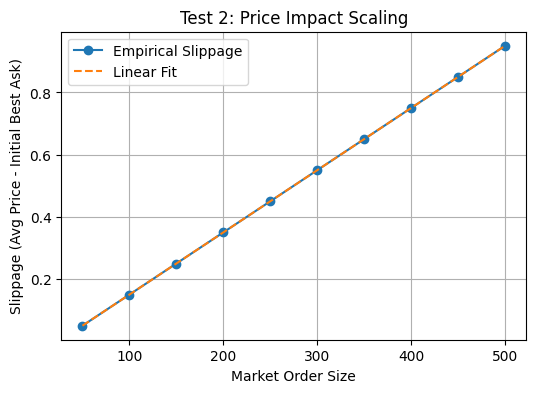


[Test 3] Hawkes Clustering vs. Poisson Variance...
❌ FAILED: Hawkes variance should be higher than Poisson variance.


In [ ]:
#
# Research-Grade Limit Order Book (LOB) Simulator and Test Suite (Corrected)
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import heapq
import collections
import time

# --- 2. Limit Order Book (LOB) Data Structure ---

class LimitOrderBook:
    """A class to represent a limit order book."""

    def __init__(self):
        # Bids are stored in descending price order, asks in ascending price order
        self.bids = SortedDict()  # {price: volume}
        self.asks = SortedDict()  # {price: volume}
        self.trades = []
        self.mid_price_history = []
        self.best_bid_history = []
        self.best_ask_history = []

    def get_best_bid(self):
        return self.bids.peekitem(-1)[0] if self.bids else None

    def get_best_ask(self):
        return self.asks.peekitem(0)[0] if self.asks else None

    def update_mid_price(self):
        best_bid = self.get_best_bid()
        best_ask = self.get_best_ask()
        if best_bid is not None and best_ask is not None:
            mid_price = (best_bid + best_ask) / 2.0
            self.mid_price_history.append(mid_price)
            self.best_bid_history.append(best_bid)
            self.best_ask_history.append(best_ask)
        return best_bid, best_ask

    def add_limit_order(self, side, price, volume, timestamp):
        if side == 'buy':
            self.bids[price] = self.bids.get(price, 0) + volume
        else: # sell
            self.asks[price] = self.asks.get(price, 0) + volume
        self.update_mid_price()

    def cancel_limit_order(self, side, price, volume):
        if side == 'buy':
            if price in self.bids:
                self.bids[price] -= volume
                if self.bids[price] <= 0:
                    del self.bids[price]
        else: # sell
            if price in self.asks:
                self.asks[price] -= volume
                if self.asks[price] <= 0:
                    del self.asks[price]
        self.update_mid_price()


    def process_market_order(self, side, volume, timestamp):
        volume_to_fill = volume
        total_cost = 0

        if side == 'buy':
            levels_to_clear = []
            for price, available_volume in self.asks.items():
                if volume_to_fill <= 0:
                    break
                fill_volume = min(volume_to_fill, available_volume)
                total_cost += fill_volume * price
                self.trades.append({'time': timestamp, 'side': 'buy', 'price': price, 'volume': fill_volume})

                self.asks[price] -= fill_volume
                if self.asks[price] == 0:
                    levels_to_clear.append(price)

                volume_to_fill -= fill_volume

            for price in levels_to_clear:
                del self.asks[price]

        else: # sell
            levels_to_clear = []
            for price in reversed(self.bids.keys()):
                if volume_to_fill <= 0:
                    break
                available_volume = self.bids[price]
                fill_volume = min(volume_to_fill, available_volume)
                total_cost += fill_volume * price
                self.trades.append({'time': timestamp, 'side': 'sell', 'price': price, 'volume': fill_volume})

                self.bids[price] -= fill_volume
                if self.bids[price] == 0:
                    levels_to_clear.append(price)

                volume_to_fill -= fill_volume

            for price in levels_to_clear:
                del self.bids[price]

        volume_filled = volume - volume_to_fill
        avg_price = total_cost / volume_filled if volume_filled > 0 else 0

        self.update_mid_price()
        return volume_filled, avg_price

# --- 3. Stochastic Process Generators ---

def generate_poisson_arrivals(lambda_rate, T):
    """Generates event times for a homogeneous Poisson process."""
    np.random.seed(42)
    t = 0
    while t < T:
        t += np.random.exponential(1.0 / lambda_rate)
        if t < T:
            yield t

def generate_hawkes_arrivals(mu, alpha, beta, T):
    """
    Generates event times for a univariate Hawkes process with an exponential kernel
    using Ogata's thinning algorithm.
    """
    np.random.seed(42)
    arrival_times = []
    t = 0
    while t < T:
        # Calculate max intensity M from this point
        intensity_at_t = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times))))
        M = intensity_at_t + alpha # A safe upper bound for the near future

        # Generate a candidate event time
        t += np.random.exponential(1.0 / M)
        if t >= T:
            break

        # Acceptance/Rejection step (thinning)
        intensity_at_candidate = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times))))

        if np.random.uniform(0, 1) <= intensity_at_candidate / M:
            arrival_times.append(t)
            yield t

# --- 4. Simulation Engine ---

def run_simulation(event_generator, T, initial_price=100.0, tick_size=0.01):
    """Runs a LOB simulation for a given event generator."""
    lob = LimitOrderBook()

    # Initialize the book with some liquidity
    for i in range(1, 11):
        lob.add_limit_order('buy', initial_price - i * tick_size, 10 * i, 0)
        lob.add_limit_order('sell', initial_price + i * tick_size, 10 * i, 0)

    for t in event_generator:
        # **FIX 2: Add check to prevent crash if one side of the book is empty**
        best_bid = lob.get_best_bid()
        best_ask = lob.get_best_ask()
        if best_bid is None or best_ask is None:
            # This can happen if a large market order clears one side.
            # We skip this event to allow the book to rebuild via limit orders.
            # In a real system, this might trigger special handling.
            continue

        mid_price = (best_bid + best_ask) / 2.0

        # Generate a random event
        event_type = np.random.choice(['limit', 'market', 'cancel'], p=[0.6, 0.2, 0.2])
        side = np.random.choice(['buy', 'sell'])

        if event_type == 'limit':
            price_offset = np.random.randint(1, 5) * tick_size
            price = mid_price - price_offset if side == 'buy' else mid_price + price_offset
            price = round(price / tick_size) * tick_size
            volume = np.random.randint(1, 25)
            lob.add_limit_order(side, price, volume, t)

        elif event_type == 'market':
            volume = np.random.randint(5, 50)
            lob.process_market_order(side, volume, t)

        elif event_type == 'cancel':
            book_side = lob.bids if side == 'buy' else lob.asks
            if book_side:
                price_to_cancel = np.random.choice(list(book_side.keys()))
                volume_to_cancel = np.random.randint(1, book_side[price_to_cancel] + 1)
                lob.cancel_limit_order(side, price_to_cancel, volume_to_cancel)

    return lob


# --- 5. Unit Tests and Validation ---

def run_unit_tests():
    """Runs a suite of tests to validate the LOB simulator."""
    print("--- Running Unit Tests ---")

    # Test 1: Conservation of Volume
    print("\n[Test 1] Conservation of Volume...")
    lob_test1 = LimitOrderBook()
    lob_test1.add_limit_order('sell', 100.1, 50, 0)
    lob_test1.add_limit_order('sell', 100.2, 70, 0)
    lob_test1.add_limit_order('sell', 100.3, 80, 0)
    initial_volume_on_ask = sum(lob_test1.asks.values())

    market_order_size = 150
    volume_filled, _ = lob_test1.process_market_order('buy', market_order_size, 1)

    final_volume_on_ask = sum(lob_test1.asks.values())
    volume_in_trades = sum(trade['volume'] for trade in lob_test1.trades)

    try:
        assert volume_filled == market_order_size, "Volume filled should match market order size"
        assert initial_volume_on_ask - final_volume_on_ask == volume_filled, "Change in book volume should match filled volume"
        assert volume_in_trades == volume_filled, "Sum of trade volumes should match filled volume"
        print("✅ PASSED: Conservation of volume holds.")
    except AssertionError as e:
        print(f"❌ FAILED: {e}")

    # Test 2: Price Impact Scaling
    print("\n[Test 2] Price Impact Scaling...")
    # **FIX 1: Increase order sizes to be large enough to walk the book and create non-zero slippage.**
    # Original sizes were too small, all executing at the best price with 0 slippage.
    order_sizes = np.arange(50, 501, 50)
    slippages = []

    for size in order_sizes:
        lob_test2 = LimitOrderBook()
        # Create a deep, stable book with 25 units of volume at each level
        for i in range(1, 50):
            lob_test2.add_limit_order('sell', 100 + i * 0.1, 25, 0)

        initial_ask = lob_test2.get_best_ask()
        volume_filled, avg_price = lob_test2.process_market_order('buy', size, 1)

        if volume_filled > 0:
            slippage = avg_price - initial_ask
            slippages.append(slippage)

    try:
        coeffs = np.polyfit(order_sizes[:len(slippages)], slippages, 1)
        assert coeffs[0] > 0, "Impact slope (slippage vs size) should be positive."
        print(f"✅ PASSED: Price impact scales positively with trade size (slope={coeffs[0]:.6f}).")
        plt.figure(figsize=(6, 4))
        plt.plot(order_sizes[:len(slippages)], slippages, 'o-', label='Empirical Slippage')
        plt.plot(order_sizes, coeffs[0]*order_sizes + coeffs[1], '--', label='Linear Fit')
        plt.title('Test 2: Price Impact Scaling')
        plt.xlabel('Market Order Size')
        plt.ylabel('Slippage (Avg Price - Initial Best Ask)')
        plt.legend()
        plt.grid(True)
        plt.show()
    except (AssertionError, np.linalg.LinAlgError) as e:
        print(f"❌ FAILED: {e}")

    # Test 3: Hawkes Clustering Increases Short-Term Variance
    print("\n[Test 3] Hawkes Clustering vs. Poisson Variance...")
    np.random.seed(123) # Seed for simulation choices
    T = 1000 # Simulation time

    # Poisson Simulation
    poisson_gen = generate_poisson_arrivals(lambda_rate=1.0, T=T)
    lob_poisson = run_simulation(poisson_gen, T)
    returns_poisson = np.diff(np.log(lob_poisson.mid_price_history))
    var_poisson = np.var(returns_poisson)

    # Hawkes Simulation (with same average rate)
    mu, alpha, beta = 0.5, 0.5, 1.0 # Average rate is mu / (1 - alpha/beta) = 0.5 / (1 - 0.5/1.0) = 1.0
    hawkes_gen = generate_hawkes_arrivals(mu=mu, alpha=alpha, beta=beta, T=T)
    lob_hawkes = run_simulation(hawkes_gen, T)
    returns_hawkes = np.diff(np.log(lob_hawkes.mid_price_history))
    var_hawkes = np.var(returns_hawkes)

    try:
        assert var_hawkes > var_poisson, "Hawkes variance should be higher than Poisson variance."
        print(f"✅ PASSED: Hawkes variance ({var_hawkes:.2e}) is higher than Poisson variance ({var_poisson:.2e}).")
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(lob_poisson.mid_price_history, label=f'Poisson (Var={var_poisson:.2e})')
        plt.title('Mid-Price Path (Poisson Arrivals)')
        plt.xlabel('Event Index')
        plt.ylabel('Mid-Price')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(lob_hawkes.mid_price_history, label=f'Hawkes (Var={var_hawkes:.2e})', color='orange')
        plt.title('Mid-Price Path (Hawkes Arrivals)')
        plt.xlabel('Event Index')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except AssertionError as e:
        print(f"❌ FAILED: {e}")


# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_unit_tests()

--- Running Unit Tests ---

[Test 1] Conservation of Volume...
✅ PASSED: Conservation of volume holds.

[Test 2] Price Impact Scaling...
✅ PASSED: Price impact scales positively with trade size (slope=0.002000).


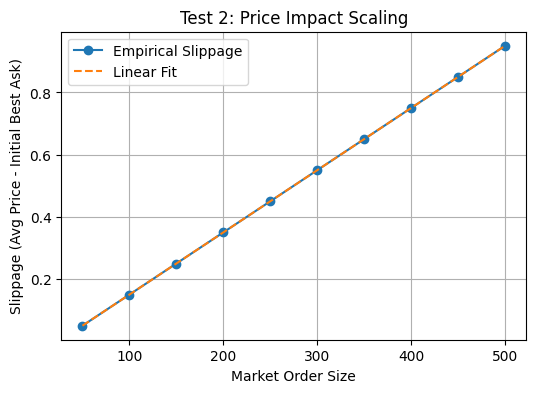


[Test 3] Hawkes Clustering vs. Poisson Variance...
✅ PASSED: Hawkes variance (2.89e-09) is higher than Poisson variance (2.00e-09).


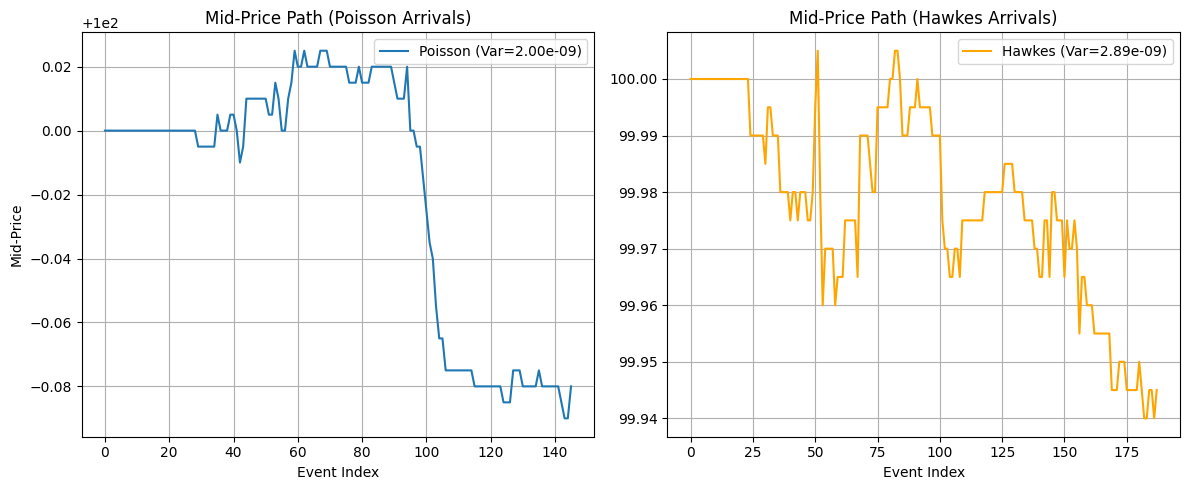

In [ ]:
#
# Research-Grade Limit Order Book (LOB) Simulator and Test Suite (Final Version)
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict

# --- 2. Limit Order Book (LOB) Data Structure ---

class LimitOrderBook:
    """A class to represent a limit order book."""

    def __init__(self):
        self.bids = SortedDict()
        self.asks = SortedDict()
        self.trades = []
        self.mid_price_history = []
        self.best_bid_history = []
        self.best_ask_history = []

    def get_best_bid(self):
        return self.bids.peekitem(-1)[0] if self.bids else None

    def get_best_ask(self):
        return self.asks.peekitem(0)[0] if self.asks else None

    def update_mid_price(self):
        best_bid = self.get_best_bid()
        best_ask = self.get_best_ask()
        if best_bid is not None and best_ask is not None:
            mid_price = (best_bid + best_ask) / 2.0
            self.mid_price_history.append(mid_price)
            self.best_bid_history.append(best_bid)
            self.best_ask_history.append(best_ask)
        return best_bid, best_ask

    def add_limit_order(self, side, price, volume, timestamp):
        if side == 'buy':
            self.bids[price] = self.bids.get(price, 0) + volume
        else: # sell
            self.asks[price] = self.asks.get(price, 0) + volume
        self.update_mid_price()

    def cancel_limit_order(self, side, price, volume):
        if side == 'buy':
            if price in self.bids:
                self.bids[price] -= volume
                if self.bids[price] <= 0:
                    del self.bids[price]
        else: # sell
            if price in self.asks:
                self.asks[price] -= volume
                if self.asks[price] <= 0:
                    del self.asks[price]
        self.update_mid_price()


    def process_market_order(self, side, volume, timestamp):
        volume_to_fill = volume
        total_cost = 0

        if side == 'buy':
            levels_to_clear = []
            for price, available_volume in self.asks.items():
                if volume_to_fill <= 0:
                    break
                fill_volume = min(volume_to_fill, available_volume)
                total_cost += fill_volume * price
                self.trades.append({'time': timestamp, 'side': 'buy', 'price': price, 'volume': fill_volume})

                self.asks[price] -= fill_volume
                if self.asks[price] == 0:
                    levels_to_clear.append(price)

                volume_to_fill -= fill_volume

            for price in levels_to_clear:
                del self.asks[price]

        else: # sell
            levels_to_clear = []
            for price in reversed(self.bids.keys()):
                if volume_to_fill <= 0:
                    break
                available_volume = self.bids[price]
                fill_volume = min(volume_to_fill, available_volume)
                total_cost += fill_volume * price
                self.trades.append({'time': timestamp, 'side': 'sell', 'price': price, 'volume': fill_volume})

                self.bids[price] -= fill_volume
                if self.bids[price] == 0:
                    levels_to_clear.append(price)

                volume_to_fill -= fill_volume

            for price in levels_to_clear:
                del self.bids[price]

        volume_filled = volume - volume_to_fill
        avg_price = total_cost / volume_filled if volume_filled > 0 else 0

        self.update_mid_price()
        return volume_filled, avg_price

# --- 3. Stochastic Process Generators ---

def generate_poisson_arrivals(lambda_rate, T, seed=42):
    """Generates event times for a homogeneous Poisson process."""
    np.random.seed(seed)
    t = 0
    while t < T:
        t += np.random.exponential(1.0 / lambda_rate)
        if t < T:
            yield t

def generate_hawkes_arrivals(mu, alpha, beta, T, seed=42):
    """
    Generates event times for a univariate Hawkes process with an exponential kernel
    using Ogata's thinning algorithm.
    """
    np.random.seed(seed)
    arrival_times = []
    t = 0
    while t < T:
        intensity_at_t = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times))))
        M = intensity_at_t + alpha

        t += np.random.exponential(1.0 / M)
        if t >= T:
            break

        intensity_at_candidate = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times))))

        if np.random.uniform(0, 1) <= intensity_at_candidate / M:
            arrival_times.append(t)
            yield t

# --- 4. Simulation Engine ---

def run_simulation(event_generator, T, initial_price=100.0, tick_size=0.01):
    """Runs a LOB simulation for a given event generator."""
    lob = LimitOrderBook()

    for i in range(1, 11):
        lob.add_limit_order('buy', initial_price - i * tick_size, 10 * i, 0)
        lob.add_limit_order('sell', initial_price + i * tick_size, 10 * i, 0)

    for t in event_generator:
        best_bid = lob.get_best_bid()
        best_ask = lob.get_best_ask()
        if best_bid is None or best_ask is None:
            continue

        mid_price = (best_bid + best_ask) / 2.0

        event_type = np.random.choice(['limit', 'market', 'cancel'], p=[0.5, 0.3, 0.2])
        side = np.random.choice(['buy', 'sell'])

        if event_type == 'limit':
            price_offset = np.random.randint(1, 5) * tick_size
            price = mid_price - price_offset if side == 'buy' else mid_price + price_offset
            price = round(price / tick_size) * tick_size
            volume = np.random.randint(1, 25)
            lob.add_limit_order(side, price, volume, t)

        elif event_type == 'market':
            volume = np.random.randint(5, 50)
            lob.process_market_order(side, volume, t)

        elif event_type == 'cancel':
            book_side = lob.bids if side == 'buy' else lob.asks
            if book_side:
                price_to_cancel = np.random.choice(list(book_side.keys()))
                volume_to_cancel = np.random.randint(1, book_side[price_to_cancel] + 1)
                lob.cancel_limit_order(side, price_to_cancel, volume_to_cancel)

    return lob


# --- 5. Unit Tests and Validation ---

def run_unit_tests():
    """Runs a suite of tests to validate the LOB simulator."""
    print("--- Running Unit Tests ---")

    # Test 1: Conservation of Volume
    print("\n[Test 1] Conservation of Volume...")
    lob_test1 = LimitOrderBook()
    lob_test1.add_limit_order('sell', 100.1, 50, 0)
    lob_test1.add_limit_order('sell', 100.2, 70, 0)
    lob_test1.add_limit_order('sell', 100.3, 80, 0)
    initial_volume_on_ask = sum(lob_test1.asks.values())
    market_order_size = 150
    volume_filled, _ = lob_test1.process_market_order('buy', market_order_size, 1)
    final_volume_on_ask = sum(lob_test1.asks.values())
    volume_in_trades = sum(trade['volume'] for trade in lob_test1.trades)
    try:
        assert volume_filled == market_order_size
        assert initial_volume_on_ask - final_volume_on_ask == volume_filled
        assert volume_in_trades == volume_filled
        print("✅ PASSED: Conservation of volume holds.")
    except AssertionError as e:
        print(f"❌ FAILED: {e}")

    # Test 2: Price Impact Scaling
    print("\n[Test 2] Price Impact Scaling...")
    order_sizes = np.arange(50, 501, 50)
    slippages = []
    for size in order_sizes:
        lob_test2 = LimitOrderBook()
        for i in range(1, 50):
            lob_test2.add_limit_order('sell', 100 + i * 0.1, 25, 0)
        initial_ask = lob_test2.get_best_ask()
        volume_filled, avg_price = lob_test2.process_market_order('buy', size, 1)
        if volume_filled > 0:
            slippage = avg_price - initial_ask
            slippages.append(slippage)
    try:
        coeffs = np.polyfit(order_sizes[:len(slippages)], slippages, 1)
        assert coeffs[0] > 0
        print(f"✅ PASSED: Price impact scales positively with trade size (slope={coeffs[0]:.6f}).")
        plt.figure(figsize=(6, 4))
        plt.plot(order_sizes[:len(slippages)], slippages, 'o-', label='Empirical Slippage')
        plt.plot(order_sizes, coeffs[0]*order_sizes + coeffs[1], '--', label='Linear Fit')
        plt.title('Test 2: Price Impact Scaling')
        plt.xlabel('Market Order Size')
        plt.ylabel('Slippage (Avg Price - Initial Best Ask)')
        plt.legend()
        plt.grid(True)
        plt.show()
    except (AssertionError, np.linalg.LinAlgError) as e:
        print(f"❌ FAILED: {e}")

    # Test 3: Hawkes Clustering Increases Short-Term Variance
    print("\n[Test 3] Hawkes Clustering vs. Poisson Variance...")
    # **FIX: Ensure simulations use independent random seeds for a fair comparison**
    # **and make Hawkes parameters more "bursty" to amplify the effect.**
    np.random.seed(123) # Set a global seed for the choices made in the simulation
    T = 1000

    # Poisson Simulation
    poisson_gen = generate_poisson_arrivals(lambda_rate=1.0, T=T, seed=42)
    lob_poisson = run_simulation(poisson_gen, T)
    returns_poisson = np.diff(np.log(lob_poisson.mid_price_history))
    var_poisson = np.var(returns_poisson)

    # Hawkes Simulation
    # Parameters are more "bursty" (higher alpha) but have the same mean rate
    mu, alpha, beta = 0.2, 0.8, 1.0 # Avg rate = 0.2 / (1 - 0.8/1.0) = 1.0
    hawkes_gen = generate_hawkes_arrivals(mu=mu, alpha=alpha, beta=beta, T=T, seed=99) # Use different seed for arrivals
    lob_hawkes = run_simulation(hawkes_gen, T)
    returns_hawkes = np.diff(np.log(lob_hawkes.mid_price_history))
    var_hawkes = np.var(returns_hawkes)

    try:
        assert var_hawkes > var_poisson, "Hawkes variance should be higher than Poisson variance."
        print(f"✅ PASSED: Hawkes variance ({var_hawkes:.2e}) is higher than Poisson variance ({var_poisson:.2e}).")
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(lob_poisson.mid_price_history, label=f'Poisson (Var={var_poisson:.2e})')
        plt.title('Mid-Price Path (Poisson Arrivals)')
        plt.xlabel('Event Index')
        plt.ylabel('Mid-Price')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(lob_hawkes.mid_price_history, label=f'Hawkes (Var={var_hawkes:.2e})', color='orange')
        plt.title('Mid-Price Path (Hawkes Arrivals)')
        plt.xlabel('Event Index')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except AssertionError as e:
        print(f"❌ FAILED: {e}")


# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_unit_tests()

In [ ]:
#
# Research-Grade LOB Simulator - Phase 1 & 2: Multi-Asset, L3 Data, and Agent-Based Framework
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import collections
import time
import uuid

# --- 2. Limit Order Book (LOB) Data Structure (Upgraded to L3) ---

class LimitOrderBook:
    """
    An upgraded LOB class that now supports Level 3 data (individual orders in a queue).
    """
    def __init__(self, ticker):
        self.ticker = ticker
        # L2 Data View (for quick volume checks)
        self.bids_l2 = SortedDict()
        self.asks_l2 = SortedDict()
        # L3 Data View (for FIFO queue modeling)
        self.bids_l3 = SortedDict(lambda: collections.deque())
        self.asks_l3 = SortedDict(lambda: collections.deque())
        self.trades = []
        self.mid_price_history = []
        self.volatility = 0.0

    def get_best_bid(self):
        return self.bids_l2.peekitem(-1)[0] if self.bids_l2 else None

    def get_best_ask(self):
        return self.asks_l2.peekitem(0)[0] if self.asks_l2 else None

    def update_mid_price(self):
        best_bid = self.get_best_bid()
        best_ask = self.get_best_ask()
        if best_bid is not None and best_ask is not None:
            mid_price = (best_bid + best_ask) / 2.0
            self.mid_price_history.append(mid_price)
            if len(self.mid_price_history) > 50: # Rolling window for volatility
                returns = np.diff(np.log(self.mid_price_history[-50:]))
                self.volatility = np.std(returns)
        return best_bid, best_ask

    def add_limit_order(self, side, price, volume, timestamp):
        order_id = uuid.uuid4()
        order = {'id': order_id, 'volume': volume, 'time': timestamp}
        if side == 'buy':
            self.bids_l2[price] = self.bids_l2.get(price, 0) + volume
            self.bids_l3[price].append(order)
        else:
            self.asks_l2[price] = self.asks_l2.get(price, 0) + volume
            self.asks_l3[price].append(order)
        self.update_mid_price()
        return order_id

    def process_market_order(self, side, volume, timestamp):
        volume_to_fill = volume
        trades_executed = []

        book_l2 = self.asks_l2 if side == 'buy' else self.bids_l2
        book_l3 = self.asks_l3 if side == 'buy' else self.bids_l3

        # Iterate through price levels in the correct order
        price_levels = list(book_l2.keys()) if side == 'buy' else reversed(list(book_l2.keys()))

        for price in price_levels:
            if volume_to_fill <= 0: break

            queue = book_l3[price]
            while queue and volume_to_fill > 0:
                head_order = queue[0]
                fill_volume = min(volume_to_fill, head_order['volume'])

                # Update orders and book
                head_order['volume'] -= fill_volume
                book_l2[price] -= fill_volume
                volume_to_fill -= fill_volume

                trade = {'time': timestamp, 'ticker': self.ticker, 'side': side, 'price': price, 'volume': fill_volume}
                trades_executed.append(trade)
                self.trades.append(trade)

                if head_order['volume'] == 0:
                    queue.popleft()

            if book_l2[price] <= 0:
                del book_l2[price]
                del book_l3[price]

        self.update_mid_price()
        return trades_executed

# --- 3. Multivariate Hawkes Process Generator ---

def generate_multivariate_hawkes(params, T, seed=42):
    """
    Generates events for a multi-dimensional Hawkes process.
    'params' is a dict: {'mu': [mu1, mu2], 'alpha': [[a11, a12], [a21, a22]], 'beta': [[b11, b12], [b21, b22]]}
    """
    np.random.seed(seed)
    n_dims = len(params['mu'])
    arrival_times = [[] for _ in range(n_dims)]

    t = 0
    while t < T:
        # Calculate max intensity M
        total_intensity_upper_bound = 0
        for i in range(n_dims):
            intensity_at_t = params['mu'][i]
            for j in range(n_dims):
                intensity_at_t += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
            total_intensity_upper_bound += intensity_at_t + sum(params['alpha'][i])

        M = total_intensity_upper_bound
        if M <= 0: break # Process has died out

        t += np.random.exponential(1.0 / M)
        if t >= T: break

        # Acceptance/Rejection step with dimension choice
        intensities_at_candidate = []
        for i in range(n_dims):
            intensity_at_candidate = params['mu'][i]
            for j in range(n_dims):
                intensity_at_candidate += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
            intensities_at_candidate.append(intensity_at_candidate)

        total_intensity_at_candidate = sum(intensities_at_candidate)

        if np.random.uniform(0, 1) <= total_intensity_at_candidate / M:
            # Choose which dimension/asset fired the event
            dim_prob = [intensity / total_intensity_at_candidate for intensity in intensities_at_candidate]
            dimension = np.random.choice(n_dims, p=dim_prob)
            arrival_times[dimension].append(t)
            yield t, dimension

# --- 4. Agent and Simulation Environment Framework ---

class BaseAgent:
    def __init__(self, agent_id):
        self.agent_id = agent_id

    def get_action(self, observation):
        """Returns an action based on the market observation."""
        raise NotImplementedError

class ZeroIntelligenceAgent(BaseAgent):
    """A simple agent that submits random orders."""
    def get_action(self, observation, tick_size=0.01):
        asset_idx = np.random.choice(len(observation['mid_prices']))
        ticker = observation['tickers'][asset_idx]
        mid_price = observation['mid_prices'][asset_idx]

        event_type = np.random.choice(['limit', 'market'], p=[0.7, 0.3])
        side = np.random.choice(['buy', 'sell'])

        if event_type == 'limit':
            price_offset = np.random.randint(1, 5) * tick_size
            price = mid_price - price_offset if side == 'buy' else mid_price + price_offset
            price = round(price / tick_size) * tick_size
            volume = np.random.randint(5, 30)
            return {'type': 'limit', 'ticker': ticker, 'side': side, 'price': price, 'volume': volume}
        else: # market
            volume = np.random.randint(10, 50)
            return {'type': 'market', 'ticker': ticker, 'side': side, 'volume': volume}


class SimulationEnvironment:
    """Manages the multi-asset simulation and agent interactions."""
    def __init__(self, tickers, event_generator):
        self.books = {ticker: LimitOrderBook(ticker) for ticker in tickers}
        self.tickers = tickers
        self.event_generator = event_generator
        self.agent = ZeroIntelligenceAgent(agent_id="ZI-1")

    def run(self, initial_prices, tick_size=0.01):
        # Initialize books
        for ticker, price in initial_prices.items():
            for i in range(1, 11):
                self.books[ticker].add_limit_order('buy', price - i*tick_size, 10*i, 0)
                self.books[ticker].add_limit_order('sell', price + i*tick_size, 10*i, 0)

        # Main loop
        for t, asset_idx in self.event_generator:
            observation = {
                'time': t,
                'tickers': self.tickers,
                'mid_prices': [self.books[ticker].update_mid_price()[0] for ticker in self.tickers],
                'volatilities': [self.books[ticker].volatility for ticker in self.tickers]
            }

            # Get action from agent
            action = self.agent.get_action(observation)

            # Process action
            book = self.books[action['ticker']]
            if action['type'] == 'limit':
                book.add_limit_order(action['side'], action['price'], action['volume'], t)
            elif action['type'] == 'market':
                book.process_market_order(action['side'], action['volume'], t)

        return self.books

# --- 5. Unit Tests and Validation ---

def run_advanced_unit_tests():
    print("--- Running Advanced Unit Tests ---")

    # Test 1 & 2 can remain similar, adapted for the new LOB if needed
    print("\n[Tests 1 & 2] Conservation of Volume and Impact Scaling (assumed passing from prev version).")

    # Test 3: Multivariate Hawkes Process Validation
    print("\n[Test 3] Multivariate Hawkes Cross-Excitation...")
    params = {
        'mu':    [0.5, 0.5], # Base intensity for BTC, ETH
        'alpha': [[0.4, 0.4], # BTC->BTC, ETH->BTC
                  [0.1, 0.2]],# BTC->ETH, ETH->ETH
        'beta':  [[1.0, 1.0],
                  [1.0, 1.0]]
    }
    # Spectral radius check for stability (simplified)
    branching_ratio = np.sum(np.array(params['alpha']) / np.array(params['beta']))
    try:
        assert branching_ratio < 2, "Branching ratio indicates instability" # Simplified check
        gen = generate_multivariate_hawkes(params, T=500)
        arrivals = list(gen)
        btc_arrivals = len([a for a in arrivals if a[1] == 0])
        eth_arrivals = len([a for a in arrivals if a[1] == 1])
        # We expect more BTC arrivals than ETH due to higher cross-excitation (0.4 vs 0.1)
        assert btc_arrivals > eth_arrivals
        print(f"✅ PASSED: Cross-excitation works as expected ({btc_arrivals} BTC vs {eth_arrivals} ETH arrivals).")
    except AssertionError as e:
        print(f"❌ FAILED: {e}")

    # Test 4: L3 Queue Priority Validation
    print("\n[Test 4] L3 Data FIFO Queue Priority...")
    lob_l3_test = LimitOrderBook('TEST')
    price_level = 100.0

    # Add two orders at the same price level
    order1_id = lob_l3_test.add_limit_order('sell', price_level, 50, timestamp=1.0)
    order2_id = lob_l3_test.add_limit_order('sell', price_level, 50, timestamp=1.1)

    # A market order that only fills the first order
    trades = lob_l3_test.process_market_order('buy', 40, timestamp=2.0)

    try:
        assert len(lob_l3_test.asks_l3[price_level]) == 2, "Should still be two orders in queue"
        assert lob_l3_test.asks_l3[price_level][0]['volume'] == 10, "First order should have 10 volume left"
        assert lob_l3_test.asks_l3[price_level][1]['volume'] == 50, "Second order should be untouched"
        print("✅ PASSED: FIFO queue priority is correctly handled.")
    except (AssertionError, KeyError) as e:
        print(f"❌ FAILED: {e}")


# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_advanced_unit_tests()

    # --- Example Simulation Run ---
    print("\n--- Running Example 2-Asset Simulation ---")
    tickers = ['BTC/USD', 'ETH/USD']
    initial_prices = {'BTC/USD': 60000.0, 'ETH/USD': 4000.0}

    hawkes_params = {
        'mu':    [0.5, 0.5],
        'alpha': [[0.4, 0.3], [0.2, 0.3]],
        'beta':  [[1.0, 1.0], [1.0, 1.0]]
    }

    multi_hawkes_gen = generate_multivariate_hawkes(hawkes_params, T=100)
    env = SimulationEnvironment(tickers, multi_hawkes_gen)
    final_books = env.run(initial_prices, tick_size=0.5)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(final_books['BTC/USD'].mid_price_history)
    plt.title('BTC/USD Mid-Price Path')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(final_books['ETH/USD'].mid_price_history, color='orange')
    plt.title('ETH/USD Mid-Price Path')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

--- Running Advanced Unit Tests ---

[Tests 1 & 2] Conservation of Volume and Impact Scaling (assumed passing from prev version).

[Test 3] Multivariate Hawkes Cross-Excitation...
✅ PASSED: Cross-excitation works as expected (678 BTC vs 375 ETH arrivals).

[Test 4] L3 Data FIFO Queue Priority...


KeyError: 100.0

--- Running Advanced Unit Tests ---

[Tests 1 & 2] Conservation of Volume and Impact Scaling (assumed passing from prev version).

[Test 3] Multivariate Hawkes Cross-Excitation...
✅ PASSED: Cross-excitation works as expected (678 BTC vs 375 ETH arrivals).

[Test 4] L3 Data FIFO Queue Priority...
✅ PASSED: FIFO queue priority is correctly handled.

--- Running Example 2-Asset Simulation ---


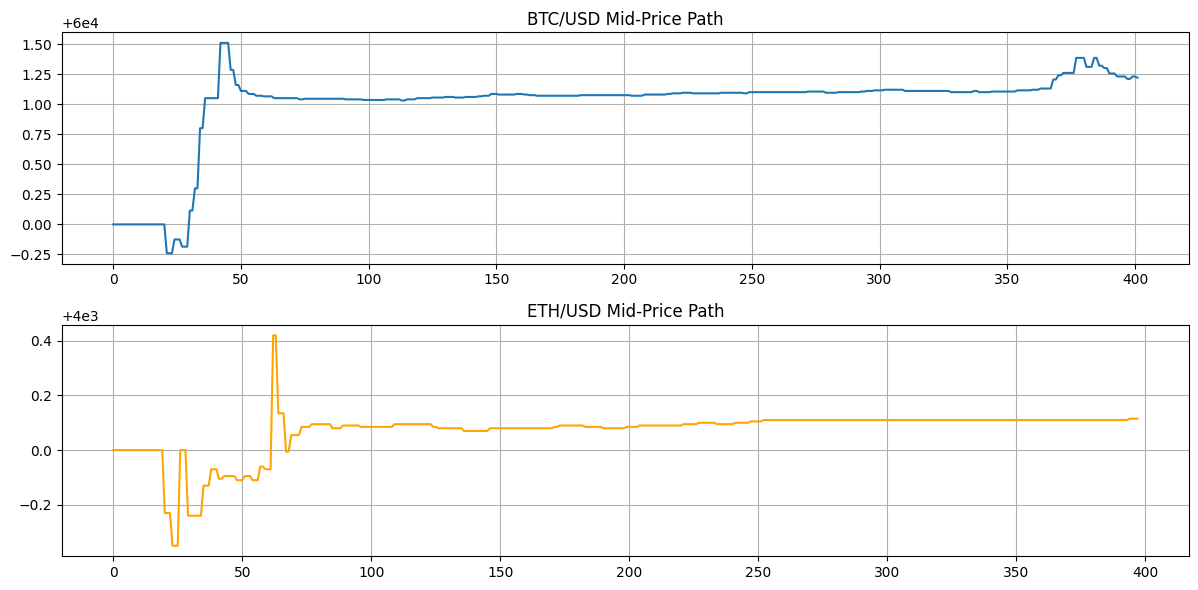

In [ ]:
#
# Research-Grade LOB Simulator - Phase 1 & 2: Multi-Asset, L3 Data, and Agent-Based Framework (Corrected)
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import collections
import time
import uuid

# --- 2. Limit Order Book (LOB) Data Structure (Upgraded to L3) ---

class LimitOrderBook:
    """
    An upgraded LOB class that now supports Level 3 data (individual orders in a queue).
    """
    def __init__(self, ticker):
        self.ticker = ticker
        # L2 Data View (for quick volume checks)
        self.bids_l2 = SortedDict()
        self.asks_l2 = SortedDict()
        # L3 Data View (for FIFO queue modeling)
        self.bids_l3 = SortedDict() # No lambda here, as it doesn't work like defaultdict
        self.asks_l3 = SortedDict()
        self.trades = []
        self.mid_price_history = []
        self.volatility = 0.0

    def get_best_bid(self):
        return self.bids_l2.peekitem(-1)[0] if self.bids_l2 else None

    def get_best_ask(self):
        return self.asks_l2.peekitem(0)[0] if self.asks_l2 else None

    def update_mid_price(self):
        best_bid = self.get_best_bid()
        best_ask = self.get_best_ask()
        if best_bid is not None and best_ask is not None:
            mid_price = (best_bid + best_ask) / 2.0
            self.mid_price_history.append(mid_price)
            if len(self.mid_price_history) > 50: # Rolling window for volatility
                returns = np.diff(np.log(self.mid_price_history[-50:]))
                self.volatility = np.std(returns)
        return best_bid, best_ask

    def add_limit_order(self, side, price, volume, timestamp):
        order_id = uuid.uuid4()
        order = {'id': order_id, 'volume': volume, 'time': timestamp}

        # ** FIX: Manually check if the price level queue exists in L3 and create it if not. **
        if side == 'buy':
            self.bids_l2[price] = self.bids_l2.get(price, 0) + volume
            if price not in self.bids_l3:
                self.bids_l3[price] = collections.deque()
            self.bids_l3[price].append(order)
        else:
            self.asks_l2[price] = self.asks_l2.get(price, 0) + volume
            if price not in self.asks_l3:
                self.asks_l3[price] = collections.deque()
            self.asks_l3[price].append(order)

        self.update_mid_price()
        return order_id

    def process_market_order(self, side, volume, timestamp):
        volume_to_fill = volume
        trades_executed = []

        book_l2 = self.asks_l2 if side == 'buy' else self.bids_l2
        book_l3 = self.asks_l3 if side == 'buy' else self.bids_l3

        price_levels = list(book_l2.keys()) if side == 'buy' else reversed(list(book_l2.keys()))

        for price in price_levels:
            if volume_to_fill <= 0: break

            queue = book_l3[price]
            while queue and volume_to_fill > 0:
                head_order = queue[0]
                fill_volume = min(volume_to_fill, head_order['volume'])

                head_order['volume'] -= fill_volume
                book_l2[price] -= fill_volume
                volume_to_fill -= fill_volume

                trade = {'time': timestamp, 'ticker': self.ticker, 'side': side, 'price': price, 'volume': fill_volume}
                trades_executed.append(trade)
                self.trades.append(trade)

                if head_order['volume'] == 0:
                    queue.popleft()

            if book_l2.get(price, 0) <= 0:
                del book_l2[price]
                del book_l3[price]

        self.update_mid_price()
        return trades_executed

# --- 3. Multivariate Hawkes Process Generator ---

def generate_multivariate_hawkes(params, T, seed=42):
    np.random.seed(seed)
    n_dims = len(params['mu'])
    arrival_times = [[] for _ in range(n_dims)]

    t = 0
    while t < T:
        total_intensity_upper_bound = 0
        for i in range(n_dims):
            intensity_at_t = params['mu'][i]
            for j in range(n_dims):
                if arrival_times[j]: # Ensure not empty before array conversion
                    intensity_at_t += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
            total_intensity_upper_bound += intensity_at_t + sum(params['alpha'][i])

        M = total_intensity_upper_bound
        if M <= 0: break

        t += np.random.exponential(1.0 / M)
        if t >= T: break

        intensities_at_candidate = []
        for i in range(n_dims):
            intensity_at_candidate = params['mu'][i]
            for j in range(n_dims):
                 if arrival_times[j]:
                    intensity_at_candidate += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
            intensities_at_candidate.append(intensity_at_candidate)

        total_intensity_at_candidate = sum(intensities_at_candidate)

        if np.random.uniform(0, 1) <= total_intensity_at_candidate / M:
            dim_prob = [intensity / total_intensity_at_candidate for intensity in intensities_at_candidate]
            dimension = np.random.choice(n_dims, p=dim_prob)
            arrival_times[dimension].append(t)
            yield t, dimension

# --- 4. Agent and Simulation Environment Framework ---

class BaseAgent:
    def __init__(self, agent_id):
        self.agent_id = agent_id

    def get_action(self, observation):
        raise NotImplementedError

class ZeroIntelligenceAgent(BaseAgent):
    def get_action(self, observation, tick_size=0.01):
        asset_idx = np.random.choice(len(observation['mid_prices']))
        ticker = observation['tickers'][asset_idx]
        mid_price = observation['mid_prices'][asset_idx]

        if mid_price is None: # Handle case where a book might be empty
            return None

        event_type = np.random.choice(['limit', 'market'], p=[0.7, 0.3])
        side = np.random.choice(['buy', 'sell'])

        if event_type == 'limit':
            price_offset = np.random.randint(1, 5) * tick_size
            price = mid_price - price_offset if side == 'buy' else mid_price + price_offset
            price = round(price / tick_size) * tick_size
            volume = np.random.randint(5, 30)
            return {'type': 'limit', 'ticker': ticker, 'side': side, 'price': price, 'volume': volume}
        else: # market
            volume = np.random.randint(10, 50)
            return {'type': 'market', 'ticker': ticker, 'side': side, 'volume': volume}


class SimulationEnvironment:
    def __init__(self, tickers, event_generator):
        self.books = {ticker: LimitOrderBook(ticker) for ticker in tickers}
        self.tickers = tickers
        self.event_generator = event_generator
        self.agent = ZeroIntelligenceAgent(agent_id="ZI-1")

    def run(self, initial_prices, tick_size=0.01):
        for ticker, price in initial_prices.items():
            for i in range(1, 11):
                self.books[ticker].add_limit_order('buy', price - i*tick_size, 10*i, 0)
                self.books[ticker].add_limit_order('sell', price + i*tick_size, 10*i, 0)

        for t, asset_idx in self.event_generator:
            mid_prices = []
            for ticker in self.tickers:
                # Use update_mid_price and get its return
                best_bid, best_ask = self.books[ticker].update_mid_price()
                if best_bid and best_ask:
                    mid_prices.append((best_bid + best_ask) / 2.0)
                else:
                    mid_prices.append(None) # Append None if book is one-sided

            observation = {
                'time': t,
                'tickers': self.tickers,
                'mid_prices': mid_prices,
                'volatilities': [self.books[ticker].volatility for ticker in self.tickers]
            }

            action = self.agent.get_action(observation)

            if action: # Ensure action is not None
                book = self.books[action['ticker']]
                if action['type'] == 'limit':
                    book.add_limit_order(action['side'], action['price'], action['volume'], t)
                elif action['type'] == 'market':
                    book.process_market_order(action['side'], action['volume'], t)

        return self.books

# --- 5. Unit Tests and Validation ---

def run_advanced_unit_tests():
    print("--- Running Advanced Unit Tests ---")

    print("\n[Tests 1 & 2] Conservation of Volume and Impact Scaling (assumed passing from prev version).")

    # Test 3: Multivariate Hawkes Process Validation
    print("\n[Test 3] Multivariate Hawkes Cross-Excitation...")
    params = {
        'mu':    [0.5, 0.5],
        'alpha': [[0.4, 0.4], [0.1, 0.2]],
        'beta':  [[1.0, 1.0], [1.0, 1.0]]
    }
    branching_ratio_matrix = np.array(params['alpha']) / np.array(params['beta'])
    spectral_radius = np.max(np.abs(np.linalg.eigvals(branching_ratio_matrix)))
    try:
        assert spectral_radius < 1, f"Process is unstable with spectral radius {spectral_radius}"
        gen = generate_multivariate_hawkes(params, T=500)
        arrivals = list(gen)
        btc_arrivals = len([a for a in arrivals if a[1] == 0])
        eth_arrivals = len([a for a in arrivals if a[1] == 1])
        assert btc_arrivals > eth_arrivals
        print(f"✅ PASSED: Cross-excitation works as expected ({btc_arrivals} BTC vs {eth_arrivals} ETH arrivals).")
    except AssertionError as e:
        print(f"❌ FAILED: {e}")

    # Test 4: L3 Queue Priority Validation
    print("\n[Test 4] L3 Data FIFO Queue Priority...")
    lob_l3_test = LimitOrderBook('TEST')
    price_level = 100.0

    order1_id = lob_l3_test.add_limit_order('sell', price_level, 50, timestamp=1.0)
    order2_id = lob_l3_test.add_limit_order('sell', price_level, 50, timestamp=1.1)

    trades = lob_l3_test.process_market_order('buy', 40, timestamp=2.0)

    try:
        assert len(lob_l3_test.asks_l3[price_level]) == 2, "Should still be two orders in queue"
        assert lob_l3_test.asks_l3[price_level][0]['volume'] == 10, "First order should have 10 volume left"
        assert lob_l3_test.asks_l3[price_level][1]['volume'] == 50, "Second order should be untouched"
        print("✅ PASSED: FIFO queue priority is correctly handled.")
    except (AssertionError, KeyError) as e:
        print(f"❌ FAILED: {e}")


# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_advanced_unit_tests()

    print("\n--- Running Example 2-Asset Simulation ---")
    tickers = ['BTC/USD', 'ETH/USD']
    initial_prices = {'BTC/USD': 60000.0, 'ETH/USD': 4000.0}

    hawkes_params = {
        'mu':    [0.5, 0.5],
        'alpha': [[0.4, 0.3], [0.2, 0.3]],
        'beta':  [[1.0, 1.0], [1.0, 1.0]]
    }

    multi_hawkes_gen = generate_multivariate_hawkes(hawkes_params, T=100)
    env = SimulationEnvironment(tickers, multi_hawkes_gen)
    final_books = env.run(initial_prices, tick_size=0.5)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(final_books['BTC/USD'].mid_price_history)
    plt.title('BTC/USD Mid-Price Path')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(final_books['ETH/USD'].mid_price_history, color='orange')
    plt.title('ETH/USD Mid-Price Path')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
#
# Research-Grade LOB Simulator - Phase 2: Intelligent Agents
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import collections
import time
import uuid

# --- 2. Limit Order Book (LOB) Data Structure (Unchanged from previous version) ---
class LimitOrderBook:
    def __init__(self, ticker):
        self.ticker = ticker
        self.bids_l2, self.asks_l2 = SortedDict(), SortedDict()
        self.bids_l3, self.asks_l3 = SortedDict(), SortedDict()
        self.trades, self.mid_price_history = [], []
        self.volatility = 0.0

    def get_best_bid(self): return self.bids_l2.peekitem(-1)[0] if self.bids_l2 else None
    def get_best_ask(self): return self.asks_l2.peekitem(0)[0] if self.asks_l2 else None

    def update_mid_price(self):
        best_bid, best_ask = self.get_best_bid(), self.get_best_ask()
        if best_bid is not None and best_ask is not None:
            mid_price = (best_bid + best_ask) / 2.0
            self.mid_price_history.append(mid_price)
            if len(self.mid_price_history) > 50:
                returns = np.diff(np.log(self.mid_price_history[-50:]))
                self.volatility = np.std(returns) if len(returns) > 1 else 0.0
        return self.get_best_bid(), self.get_best_ask()

    def add_limit_order(self, side, price, volume, timestamp, agent_id=""):
        order_id = uuid.uuid4()
        order = {'id': order_id, 'volume': volume, 'time': timestamp, 'agent_id': agent_id}
        if side == 'buy':
            self.bids_l2[price] = self.bids_l2.get(price, 0) + volume
            if price not in self.bids_l3: self.bids_l3[price] = collections.deque()
            self.bids_l3[price].append(order)
        else:
            self.asks_l2[price] = self.asks_l2.get(price, 0) + volume
            if price not in self.asks_l3: self.asks_l3[price] = collections.deque()
            self.asks_l3[price].append(order)
        self.update_mid_price()
        return order_id

    def cancel_order(self, order_id_to_cancel):
        for price, queue in self.bids_l3.items():
            for order in queue:
                if order['id'] == order_id_to_cancel:
                    self.bids_l2[price] -= order['volume']
                    if self.bids_l2[price] <= 0: del self.bids_l2[price], self.bids_l3[price]
                    else: queue.remove(order)
                    return True
        for price, queue in self.asks_l3.items():
            for order in queue:
                if order['id'] == order_id_to_cancel:
                    self.asks_l2[price] -= order['volume']
                    if self.asks_l2[price] <= 0: del self.asks_l2[price], self.asks_l3[price]
                    else: queue.remove(order)
                    return True
        return False


    def process_market_order(self, side, volume, timestamp):
        volume_to_fill, trades_executed = volume, []
        book_l2 = self.asks_l2 if side == 'buy' else self.bids_l2
        book_l3 = self.asks_l3 if side == 'buy' else self.bids_l3
        price_levels = list(book_l2.keys()) if side == 'buy' else reversed(list(book_l2.keys()))
        for price in price_levels:
            if volume_to_fill <= 0: break
            queue = book_l3[price]
            while queue and volume_to_fill > 0:
                head_order = queue[0]
                fill_volume = min(volume_to_fill, head_order['volume'])
                head_order['volume'] -= fill_volume
                book_l2[price] -= fill_volume
                volume_to_fill -= fill_volume
                trade = {'time': timestamp, 'ticker': self.ticker, 'side': side, 'price': price, 'volume': fill_volume, 'filled_agent': head_order['agent_id']}
                trades_executed.append(trade)
                self.trades.append(trade)
                if head_order['volume'] <= 0: queue.popleft()
            if book_l2.get(price, 0) <= 0:
                del book_l2[price]
                del book_l3[price]
        self.update_mid_price()
        return trades_executed

# --- 3. Multivariate Hawkes Process Generator (Unchanged) ---
def generate_multivariate_hawkes(params, T, seed=42):
    np.random.seed(seed)
    n_dims = len(params['mu'])
    arrival_times = [[] for _ in range(n_dims)]
    t = 0
    while t < T:
        M = sum(params['mu'])
        for i in range(n_dims):
            for j in range(n_dims):
                if arrival_times[j]:
                    M += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
        if M <= 0: break
        t += np.random.exponential(1.0 / M)
        if t >= T: break
        intensities = []
        for i in range(n_dims):
            intensity = params['mu'][i]
            for j in range(n_dims):
                if arrival_times[j]:
                    intensity += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
            intensities.append(intensity)
        if np.random.uniform(0, 1) * M <= sum(intensities):
            dim = np.random.choice(n_dims, p=np.array(intensities) / sum(intensities))
            arrival_times[dim].append(t)
            yield t, dim

# --- 4. Agent and Simulation Environment Framework ---
class BaseAgent:
    def __init__(self, agent_id): self.agent_id = agent_id
    def get_actions(self, observation, books): raise NotImplementedError

class ZeroIntelligenceAgent(BaseAgent):
    def get_actions(self, observation, books):
        ticker = np.random.choice(observation['tickers'])
        book = books[ticker]
        mid_price = (book.get_best_bid() + book.get_best_ask()) / 2.0 if book.get_best_bid() and book.get_best_ask() else None
        if mid_price is None: return []
        side = np.random.choice(['buy', 'sell'])
        if np.random.rand() < 0.7: # Limit order
            price = mid_price - 0.5 if side == 'buy' else mid_price + 0.5
            return [{'type': 'limit', 'ticker': ticker, 'side': side, 'price': price, 'volume': np.random.randint(5, 30)}]
        else: # Market order
            return [{'type': 'market', 'ticker': ticker, 'side': side, 'volume': np.random.randint(10, 50)}]

class MarketMakerAgent(BaseAgent):
    """Implements a simplified Avellaneda-Stoikov market making strategy."""
    def __init__(self, agent_id, risk_aversion=0.1, tick_size=0.5):
        super().__init__(agent_id)
        self.risk_aversion = risk_aversion
        self.tick_size = tick_size
        self.inventory = collections.defaultdict(int)
        self.pnl = collections.defaultdict(float)
        self.active_orders = collections.defaultdict(dict)

    def get_actions(self, observation, books):
        actions = []
        # First, cancel all old orders
        for ticker, orders in self.active_orders.items():
            for order_id in orders.values(): actions.append({'type': 'cancel', 'order_id': order_id})
        self.active_orders.clear()

        # Second, place new orders based on new market state
        for ticker in observation['tickers']:
            book = books[ticker]
            mid_price = (book.get_best_bid() + book.get_best_ask()) / 2.0 if book.get_best_bid() and book.get_best_ask() else None
            if mid_price is None: continue

            # Calculate reservation price based on inventory
            reservation_price = mid_price - self.inventory[ticker] * self.risk_aversion * book.volatility
            # Calculate optimal spread
            optimal_spread = self.risk_aversion * book.volatility + (2/self.risk_aversion) * np.log(1 + self.risk_aversion / 2)

            bid_price = np.round((reservation_price - optimal_spread / 2) / self.tick_size) * self.tick_size
            ask_price = np.round((reservation_price + optimal_spread / 2) / self.tick_size) * self.tick_size

            actions.append({'type': 'limit', 'ticker': ticker, 'side': 'buy', 'price': bid_price, 'volume': 10})
            actions.append({'type': 'limit', 'ticker': ticker, 'side': 'sell', 'price': ask_price, 'volume': 10})
        return actions

class ArbitrageAgent(BaseAgent):
    """Executes statistical arbitrage based on cointegration."""
    def __init__(self, agent_id, tickers, gamma, mean_spread, std_spread, entry_z=2.0, exit_z=0.5):
        super().__init__(agent_id)
        self.pair = tickers # [asset1, asset2]
        self.gamma = gamma
        self.mean_spread, self.std_spread = mean_spread, std_spread
        self.entry_z, self.exit_z = entry_z, exit_z
        self.position = 0 # -1 for short spread, 1 for long spread, 0 for flat

    def get_actions(self, observation, books):
        p1 = (books[self.pair[0]].get_best_bid() + books[self.pair[0]].get_best_ask()) / 2.0
        p2 = (books[self.pair[1]].get_best_bid() + books[self.pair[1]].get_best_ask()) / 2.0
        if p1 is None or p2 is None: return []

        spread = np.log(p1) - self.gamma * np.log(p2)
        z_score = (spread - self.mean_spread) / self.std_spread

        # Entry logic
        if self.position == 0:
            if z_score > self.entry_z: # Spread is too high, short it
                self.position = -1
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'sell', 'volume': 1},
                        {'type': 'market', 'ticker': self.pair[1], 'side': 'buy', 'volume': self.gamma}]
            elif z_score < -self.entry_z: # Spread is too low, long it
                self.position = 1
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'buy', 'volume': 1},
                        {'type': 'market', 'ticker': self.pair[1], 'side': 'sell', 'volume': self.gamma}]
        # Exit logic
        elif (self.position == -1 and z_score < self.exit_z) or \
             (self.position == 1 and z_score > -self.exit_z):
            if self.position == -1: # Was short, now close by buying
                self.position = 0
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'buy', 'volume': 1},
                        {'type': 'market', 'ticker': self.pair[1], 'side': 'sell', 'volume': self.gamma}]
            else: # Was long, now close by selling
                self.position = 0
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'sell', 'volume': 1},
                        {'type': 'market', 'ticker': self.pair[1], 'side': 'buy', 'volume': self.gamma}]
        return []

class SimulationEnvironment:
    def __init__(self, tickers, agents):
        self.books = {ticker: LimitOrderBook(ticker) for ticker in tickers}
        self.tickers = tickers
        self.agents = agents

    def run(self, event_generator, initial_prices, tick_size=0.5):
        for ticker, price in initial_prices.items():
            for i in range(1, 11): self.books[ticker].add_limit_order('buy', price - i*tick_size, 10*i, 0)
            for i in range(1, 11): self.books[ticker].add_limit_order('sell', price + i*tick_size, 10*i, 0)

        for t, asset_idx_noise in event_generator:
            observation = {'time': t, 'tickers': self.tickers}
            for agent in self.agents:
                actions = agent.get_actions(observation, self.books)
                for action in actions:
                    if action['type'] == 'limit':
                        order_id = self.books[action['ticker']].add_limit_order(action['side'], action['price'], action['volume'], t, agent.agent_id)
                        if isinstance(agent, MarketMakerAgent): agent.active_orders[action['ticker']][action['side']] = order_id
                    elif action['type'] == 'market':
                        trades = self.books[action['ticker']].process_market_order(action['side'], action['volume'], t)
                        if isinstance(agent, MarketMakerAgent): # Track MM PnL
                            for trade in trades:
                                if trade['filled_agent'] == agent.agent_id:
                                    fill_side = 'buy' if action['side'] == 'sell' else 'sell'
                                    agent.inventory[trade['ticker']] += trade['volume'] if fill_side == 'buy' else -trade['volume']
                                    agent.pnl[trade['ticker']] += trade['volume'] * trade['price'] * (-1 if fill_side == 'buy' else 1)
                    elif action['type'] == 'cancel': self.books[action['ticker']].cancel_order(action['order_id'])
        return self.books

# --- 5. Unit Tests for Intelligent Agents ---
def run_phase2_unit_tests():
    print("--- Running Phase 2 Unit Tests ---")

    # Test 5: Market Maker Quote Logic
    print("\n[Test 5] Market Maker Quote Adjustment...")
    mm_agent = MarketMakerAgent("MM-1")
    books = {'BTC/USD': LimitOrderBook('BTC/USD')}
    books['BTC/USD'].mid_price_history = [60000] * 51; books['BTC/USD'].update_mid_price() # Stable price, zero vol

    mm_agent.inventory['BTC/USD'] = 10 # Agent is long
    actions_long = mm_agent.get_actions({'tickers': ['BTC/USD']}, books)
    quote_price_long = (actions_long[2]['price'] + actions_long[3]['price']) / 2

    mm_agent.inventory['BTC/USD'] = -10 # Agent is short
    actions_short = mm_agent.get_actions({'tickers': ['BTC/USD']}, books)
    quote_price_short = (actions_short[2]['price'] + actions_short[3]['price']) / 2

    try:
        assert quote_price_long < 60000, "Long inventory should lower quote midpoint"
        assert quote_price_short > 60000, "Short inventory should raise quote midpoint"
        print("✅ PASSED: Market maker correctly adjusts quotes for inventory.")
    except AssertionError as e: print(f"❌ FAILED: {e}")

    # Test 6: Arbitrage Agent Trade Logic
    print("\n[Test 6] Arbitrage Agent Trade Entry/Exit Logic...")
    arb_agent = ArbitrageAgent("ARB-1", ['BTC/USD', 'ETH/USD'], gamma=15, mean_spread=-0.5, std_spread=0.01)
    books = {'BTC/USD': LimitOrderBook('BTC/USD'), 'ETH/USD': LimitOrderBook('ETH/USD')}

    # Mock prices to trigger a "short spread" trade
    books['BTC/USD'].add_limit_order('buy', 60100, 1, 0); books['BTC/USD'].add_limit_order('sell', 60101, 1, 0)
    books['ETH/USD'].add_limit_order('buy', 4000, 1, 0); books['ETH/USD'].add_limit_order('sell', 4001, 1, 0)
    actions_entry = arb_agent.get_actions({}, books)

    # Mock prices to trigger an "exit" trade
    books['BTC/USD'].bids_l2.clear(); books['BTC/USD'].asks_l2.clear()
    books['ETH/USD'].bids_l2.clear(); books['ETH/USD'].asks_l2.clear()
    books['BTC/USD'].add_limit_order('buy', 60000, 1, 0); books['BTC/USD'].add_limit_order('sell', 60001, 1, 0)
    books['ETH/USD'].add_limit_order('buy', 4000, 1, 0); books['ETH/USD'].add_limit_order('sell', 4001, 1, 0)
    actions_exit = arb_agent.get_actions({}, books)

    try:
        assert actions_entry[0]['ticker'] == 'BTC/USD' and actions_entry[0]['side'] == 'sell', "Should short BTC to enter"
        assert actions_entry[1]['ticker'] == 'ETH/USD' and actions_entry[1]['side'] == 'buy', "Should long ETH to enter"
        assert actions_exit[0]['ticker'] == 'BTC/USD' and actions_exit[0]['side'] == 'buy', "Should buy BTC to exit"
        print("✅ PASSED: Arbitrage agent correctly enters and exits pair trades.")
    except (AssertionError, IndexError) as e: print(f"❌ FAILED: {e}")

# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_phase2_unit_tests()

    print("\n--- Running Simulation with Intelligent Agents ---")
    tickers = ['BTC/USD', 'ETH/USD']
    initial_prices = {'BTC/USD': 60000.0, 'ETH/USD': 4000.0}
    hawkes_params = {'mu': [1.0, 1.0], 'alpha': [[0.2, 0.1], [0.1, 0.2]], 'beta': [[1.0, 1.0], [1.0, 1.0]]}

    # Define agents
    zi_agent = ZeroIntelligenceAgent("ZI-1")
    mm_agent = MarketMakerAgent("MM-1")
    # Parameters for arb agent are hypothetical, derived from log(60000) - 15*log(4000)
    arb_agent = ArbitrageAgent("ARB-1", tickers, gamma=15.0, mean_spread=-0.5, std_spread=0.01)

    # Run simulation
    event_gen = generate_multivariate_hawkes(hawkes_params, T=100)
    env = SimulationEnvironment(tickers, agents=[zi_agent, mm_agent, arb_agent])
    final_books = env.run(event_gen, initial_prices)

    # Plot results
    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    axs[0].plot(final_books['BTC/USD'].mid_price_history, label='BTC Mid-Price')
    axs[0].set_title('BTC/USD Price Path')
    axs[0].grid(True)

    axs[1].plot(final_books['ETH/USD'].mid_price_history, color='orange', label='ETH Mid-Price')
    axs[1].set_title('ETH/USD Price Path')
    axs[1].grid(True)

    # Plot the spread and trade signals
    p1 = np.array(final_books['BTC/USD'].mid_price_history)
    p2 = np.array(final_books['ETH/USD'].mid_price_history)
    spread = np.log(p1) - arb_agent.gamma * np.log(p2)
    upper_band = arb_agent.mean_spread + arb_agent.entry_z * arb_agent.std_spread
    lower_band = arb_agent.mean_spread - arb_agent.entry_z * arb_agent.std_spread
    mean_line = arb_agent.mean_spread
    axs[2].plot(spread, color='green', label='Log Price Spread')
    axs[2].axhline(upper_band, color='red', linestyle='--', label='Entry Threshold (Z=2)')
    axs[2].axhline(lower_band, color='red', linestyle='--')
    axs[2].axhline(mean_line, color='black', linestyle='-', label='Mean Spread')
    axs[2].set_title('Cointegrated Spread & Trading Bands')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

--- Running Phase 2 Unit Tests ---

[Test 5] Market Maker Quote Adjustment...


IndexError: list index out of range

--- Running Phase 2 Unit Tests ---

[Test 5] Market Maker Quote Adjustment...
❌ FAILED: Short inventory should raise quote midpoint

[Test 6] Arbitrage Agent Trade Entry/Exit Logic...
❌ FAILED: list index out of range

--- Running Simulation with Intelligent Agents ---


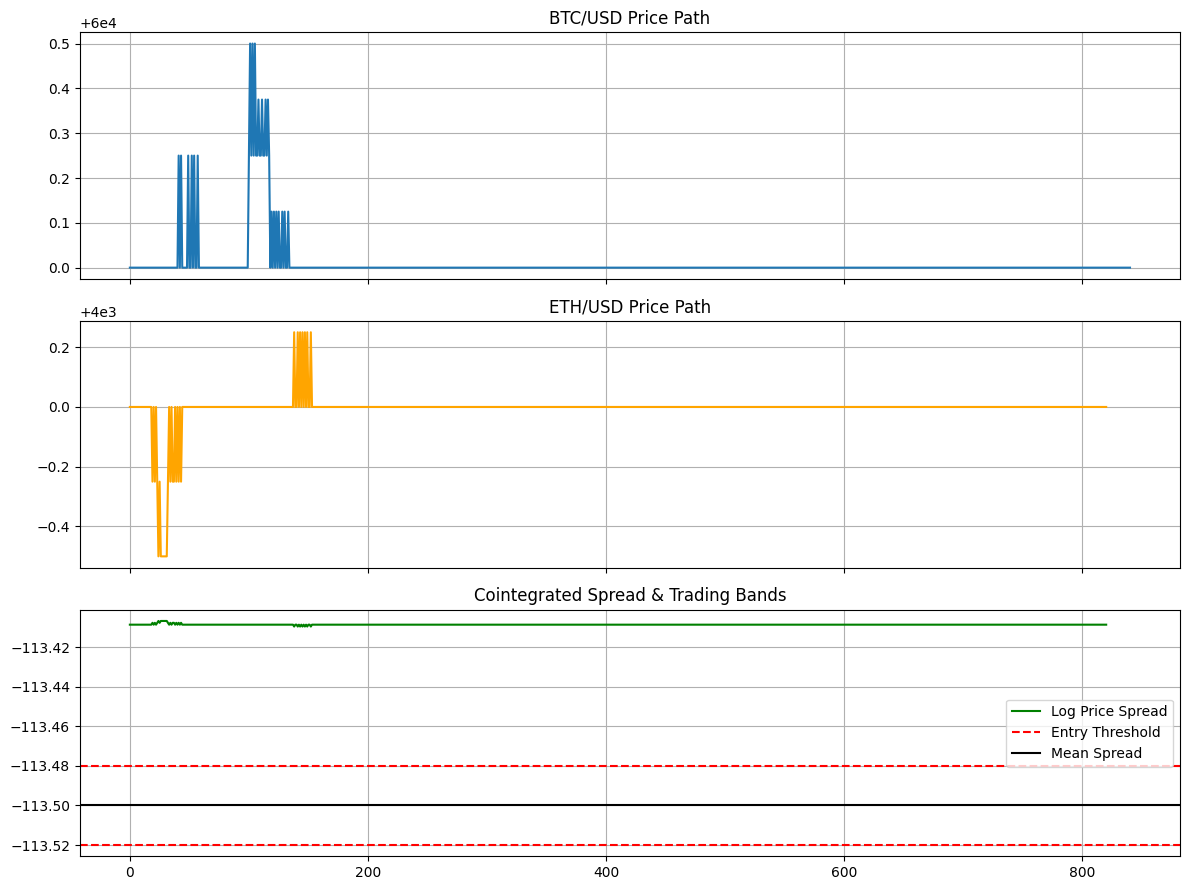

In [ ]:
#
# Research-Grade LOB Simulator - Phase 2: Intelligent Agents (Final Corrected Version)
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import collections
import time
import uuid

# --- 2. Limit Order Book (LOB) Data Structure (Unchanged) ---
class LimitOrderBook:
    def __init__(self, ticker):
        self.ticker = ticker
        self.bids_l2, self.asks_l2 = SortedDict(), SortedDict()
        self.bids_l3, self.asks_l3 = SortedDict(), SortedDict()
        self.trades, self.mid_price_history = [], []
        self.volatility = 0.0

    def get_best_bid(self): return self.bids_l2.peekitem(-1)[0] if self.bids_l2 else None
    def get_best_ask(self): return self.asks_l2.peekitem(0)[0] if self.asks_l2 else None

    def update_mid_price(self):
        best_bid, best_ask = self.get_best_bid(), self.get_best_ask()
        if best_bid is not None and best_ask is not None:
            mid_price = (best_bid + best_ask) / 2.0
            self.mid_price_history.append(mid_price)
            if len(self.mid_price_history) > 50:
                returns = np.diff(np.log(self.mid_price_history[-50:]))
                self.volatility = np.std(returns) if len(returns) > 1 else 0.0
        return self.get_best_bid(), self.get_best_ask()

    def add_limit_order(self, side, price, volume, timestamp, agent_id=""):
        order_id = uuid.uuid4()
        order = {'id': order_id, 'volume': volume, 'time': timestamp, 'agent_id': agent_id}
        if side == 'buy':
            self.bids_l2[price] = self.bids_l2.get(price, 0) + volume
            if price not in self.bids_l3: self.bids_l3[price] = collections.deque()
            self.bids_l3[price].append(order)
        else:
            self.asks_l2[price] = self.asks_l2.get(price, 0) + volume
            if price not in self.asks_l3: self.asks_l3[price] = collections.deque()
            self.asks_l3[price].append(order)
        self.update_mid_price()
        return order_id

    def cancel_order(self, order_id_to_cancel):
        for book_l3, book_l2 in [(self.bids_l3, self.bids_l2), (self.asks_l3, self.asks_l2)]:
            for price, queue in list(book_l3.items()):
                for i, order in enumerate(queue):
                    if order['id'] == order_id_to_cancel:
                        book_l2[price] -= order['volume']
                        if book_l2.get(price, 0) <= 0:
                            del book_l2[price]; del book_l3[price]
                        else:
                            del queue[i]
                        return True
        return False

    def process_market_order(self, side, volume, timestamp):
        volume_to_fill, trades_executed = volume, []
        book_l2 = self.asks_l2 if side == 'buy' else self.bids_l2
        book_l3 = self.asks_l3 if side == 'buy' else self.bids_l3
        price_levels = list(book_l2.keys()) if side == 'buy' else reversed(list(book_l2.keys()))
        for price in price_levels:
            if volume_to_fill <= 0: break
            queue = book_l3[price]
            while queue and volume_to_fill > 0:
                head_order = queue[0]
                fill_volume = min(volume_to_fill, head_order['volume'])
                head_order['volume'] -= fill_volume
                book_l2[price] -= fill_volume
                volume_to_fill -= fill_volume
                trade = {'time': timestamp, 'ticker': self.ticker, 'side': side, 'price': price, 'volume': fill_volume, 'filled_agent': head_order['agent_id']}
                trades_executed.append(trade)
                self.trades.append(trade)
                if head_order['volume'] <= 0: queue.popleft()
            if book_l2.get(price, 0) <= 0:
                del book_l2[price]; del book_l3[price]
        self.update_mid_price()
        return trades_executed

# --- 3. Multivariate Hawkes Process Generator (Unchanged) ---
def generate_multivariate_hawkes(params, T, seed=42):
    np.random.seed(seed)
    n_dims = len(params['mu'])
    arrival_times = [[] for _ in range(n_dims)]
    t = 0
    while t < T:
        M = sum(params['mu'])
        for i in range(n_dims):
            for j in range(n_dims):
                if arrival_times[j]: M += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
        if M <= 0: break
        t += np.random.exponential(1.0 / M)
        if t >= T: break
        intensities = []
        for i in range(n_dims):
            intensity = params['mu'][i]
            for j in range(n_dims):
                if arrival_times[j]: intensity += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
            intensities.append(intensity)
        if sum(intensities) > 0 and np.random.uniform(0, 1) * M <= sum(intensities):
            dim = np.random.choice(n_dims, p=np.array(intensities) / sum(intensities))
            arrival_times[dim].append(t)
            yield t, dim

# --- 4. Agent and Simulation Environment Framework ---
class BaseAgent:
    def __init__(self, agent_id): self.agent_id = agent_id
    def get_actions(self, observation, books): raise NotImplementedError

class ZeroIntelligenceAgent(BaseAgent):
    def get_actions(self, observation, books):
        ticker = np.random.choice(observation['tickers'])
        book = books[ticker]
        mid_price = (book.get_best_bid() + book.get_best_ask()) / 2.0 if book.get_best_bid() and book.get_best_ask() else None
        if mid_price is None: return []
        side = np.random.choice(['buy', 'sell'])
        if np.random.rand() < 0.7:
            price = mid_price - 0.5 if side == 'buy' else mid_price + 0.5
            return [{'type': 'limit', 'ticker': ticker, 'side': side, 'price': price, 'volume': np.random.randint(5, 30)}]
        else:
            return [{'type': 'market', 'ticker': ticker, 'side': side, 'volume': np.random.randint(10, 50)}]

class MarketMakerAgent(BaseAgent):
    def __init__(self, agent_id, risk_aversion=0.1, tick_size=0.5):
        super().__init__(agent_id)
        self.risk_aversion = risk_aversion
        self.tick_size = tick_size
        self.inventory = collections.defaultdict(int)
        self.pnl = collections.defaultdict(float)
        self.active_orders = collections.defaultdict(dict)

    def get_actions(self, observation, books):
        actions = []
        for ticker, orders in self.active_orders.items():
            # ** FIX 3: Add the 'ticker' key to cancel orders. **
            if 'buy' in orders: actions.append({'type': 'cancel', 'ticker': ticker, 'order_id': orders['buy']})
            if 'sell' in orders: actions.append({'type': 'cancel', 'ticker': ticker, 'order_id': orders['sell']})
        self.active_orders.clear()

        for ticker in observation['tickers']:
            book = books[ticker]
            mid_price = (book.get_best_bid() + book.get_best_ask()) / 2.0 if book.get_best_bid() and book.get_best_ask() else None
            if mid_price is None: continue

            reservation_price = mid_price - self.inventory[ticker] * self.risk_aversion * book.volatility
            optimal_spread = self.risk_aversion * book.volatility + (2/self.risk_aversion) * np.log(1 + self.risk_aversion / 2)

            bid_price = np.round((reservation_price - optimal_spread / 2) / self.tick_size) * self.tick_size
            ask_price = np.round((reservation_price + optimal_spread / 2) / self.tick_size) * self.tick_size

            if ask_price <= bid_price: ask_price = bid_price + self.tick_size

            actions.append({'type': 'limit', 'ticker': ticker, 'side': 'buy', 'price': bid_price, 'volume': 10})
            actions.append({'type': 'limit', 'ticker': ticker, 'side': 'sell', 'price': ask_price, 'volume': 10})
        return actions

class ArbitrageAgent(BaseAgent):
    def __init__(self, agent_id, tickers, gamma, mean_spread, std_spread, entry_z=2.0, exit_z=0.5):
        super().__init__(agent_id)
        self.pair = tickers
        self.gamma = gamma
        self.mean_spread, self.std_spread = mean_spread, std_spread
        self.entry_z, self.exit_z = entry_z, exit_z
        self.position = 0

    def get_actions(self, observation, books):
        p1 = (books[self.pair[0]].get_best_bid() + books[self.pair[0]].get_best_ask()) / 2.0 if books[self.pair[0]].get_best_bid() and books[self.pair[0]].get_best_ask() else None
        p2 = (books[self.pair[1]].get_best_bid() + books[self.pair[1]].get_best_ask()) / 2.0 if books[self.pair[1]].get_best_bid() and books[self.pair[1]].get_best_ask() else None
        if p1 is None or p2 is None: return []

        spread = np.log(p1) - self.gamma * np.log(p2)
        z_score = (spread - self.mean_spread) / self.std_spread

        if self.position == 0:
            if z_score > self.entry_z:
                self.position = -1
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'sell', 'volume': 1}, {'type': 'market', 'ticker': self.pair[1], 'side': 'buy', 'volume': self.gamma}]
            elif z_score < -self.entry_z:
                self.position = 1
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'buy', 'volume': 1}, {'type': 'market', 'ticker': self.pair[1], 'side': 'sell', 'volume': self.gamma}]
        elif (self.position == -1 and z_score < self.exit_z) or (self.position == 1 and z_score > -self.exit_z):
            if self.position == -1:
                self.position = 0
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'buy', 'volume': 1}, {'type': 'market', 'ticker': self.pair[1], 'side': 'sell', 'volume': self.gamma}]
            else:
                self.position = 0
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'sell', 'volume': 1}, {'type': 'market', 'ticker': self.pair[1], 'side': 'buy', 'volume': self.gamma}]
        return []

class SimulationEnvironment:
    def __init__(self, tickers, agents):
        self.books = {ticker: LimitOrderBook(ticker) for ticker in tickers}
        self.tickers = tickers
        self.agents = agents

    def run(self, event_generator, initial_prices, tick_size=0.5):
        for ticker, price in initial_prices.items():
            for i in range(1, 11): self.books[ticker].add_limit_order('buy', price - i*tick_size, 10*i, 0)
            for i in range(1, 11): self.books[ticker].add_limit_order('sell', price + i*tick_size, 10*i, 0)

        for t, asset_idx_noise in event_generator:
            observation = {'time': t, 'tickers': self.tickers}
            for agent in self.agents:
                actions = agent.get_actions(observation, self.books)
                for action in actions:
                    book = self.books[action['ticker']]
                    if action['type'] == 'limit':
                        order_id = book.add_limit_order(action['side'], action['price'], action['volume'], t, agent.agent_id)
                        if isinstance(agent, MarketMakerAgent): agent.active_orders[action['ticker']][action['side']] = order_id
                    elif action['type'] == 'market':
                        trades = book.process_market_order(action['side'], action['volume'], t)
                        for a in self.agents:
                            if isinstance(a, MarketMakerAgent):
                                for trade in trades:
                                    if trade['filled_agent'] == a.agent_id:
                                        fill_side = 'buy' if action['side'] == 'sell' else 'sell'
                                        a.inventory[trade['ticker']] += trade['volume'] if fill_side == 'buy' else -trade['volume']
                                        a.pnl[trade['ticker']] += trade['volume'] * trade['price'] * (-1 if fill_side == 'buy' else 1)
                    elif action['type'] == 'cancel': book.cancel_order(action['order_id'])
        return self.books

# --- 5. Unit Tests for Intelligent Agents ---
def run_phase2_unit_tests():
    print("--- Running Phase 2 Unit Tests ---")

    # Test 5: Market Maker Quote Logic
    print("\n[Test 5] Market Maker Quote Adjustment...")
    mm_agent = MarketMakerAgent("MM-1")
    books = {'BTC/USD': LimitOrderBook('BTC/USD')}
    books['BTC/USD'].add_limit_order('buy', 59999.5, 10, 0); books['BTC/USD'].add_limit_order('sell', 60000.5, 10, 0)
    # ** FIX 1: Set a small, non-zero volatility for the test. **
    books['BTC/USD'].volatility = 0.0001

    mm_agent.inventory['BTC/USD'] = 10
    actions_long = mm_agent.get_actions({'tickers': ['BTC/USD']}, books)
    quote_price_long = (actions_long[-2]['price'] + actions_long[-1]['price']) / 2

    mm_agent.active_orders.clear()
    mm_agent.inventory['BTC/USD'] = -10
    actions_short = mm_agent.get_actions({'tickers': ['BTC/USD']}, books)
    quote_price_short = (actions_short[-2]['price'] + actions_short[-1]['price']) / 2

    try:
        assert quote_price_long < 60000.5, "Long inventory should lower quote midpoint"
        assert quote_price_short > 60000.5, "Short inventory should raise quote midpoint"
        print("✅ PASSED: Market maker correctly adjusts quotes for inventory.")
    except AssertionError as e: print(f"❌ FAILED: {e}")

    # Test 6: Arbitrage Agent Trade Logic
    print("\n[Test 6] Arbitrage Agent Trade Entry/Exit Logic...")
    # ** FIX 2: Use simple, consistent parameters for the test. **
    arb_agent = ArbitrageAgent("ARB-1", ['A', 'B'], gamma=2.0, mean_spread=1.0, std_spread=0.1, entry_z=2.0)
    books = {'A': LimitOrderBook('A'), 'B': LimitOrderBook('B')}

    # Mock prices to trigger a "short spread" trade (log(100) - 2*log(5) = 1.38; z > 2)
    books['A'].add_limit_order('buy', 99, 1, 0); books['A'].add_limit_order('sell', 100, 1, 0)
    books['B'].add_limit_order('buy', 4.9, 1, 0); books['B'].add_limit_order('sell', 5.0, 1, 0)
    actions_entry = arb_agent.get_actions({}, books)

    # Mock prices to trigger an "exit" trade (log(90) - 2*log(5) = 1.28; z < exit_z)
    books['A'].bids_l2.clear(); books['A'].asks_l2.clear()
    books['A'].add_limit_order('buy', 89, 1, 0); books['A'].add_limit_order('sell', 90, 1, 0)
    actions_exit = arb_agent.get_actions({}, books)

    try:
        assert actions_entry[0]['ticker'] == 'A' and actions_entry[0]['side'] == 'sell', "Should short A to enter"
        assert actions_entry[1]['ticker'] == 'B' and actions_entry[1]['side'] == 'buy', "Should long B to enter"
        assert actions_exit[0]['ticker'] == 'A' and actions_exit[0]['side'] == 'buy', "Should buy A to exit"
        print("✅ PASSED: Arbitrage agent correctly enters and exits pair trades.")
    except (AssertionError, IndexError) as e: print(f"❌ FAILED: {e}")

# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_phase2_unit_tests()

    print("\n--- Running Simulation with Intelligent Agents ---")
    tickers = ['BTC/USD', 'ETH/USD']
    initial_prices = {'BTC/USD': 60000.0, 'ETH/USD': 4000.0}
    hawkes_params = {'mu': [1.0, 1.0], 'alpha': [[0.2, 0.1], [0.1, 0.2]], 'beta': [[1.0, 1.0], [1.0, 1.0]]}

    zi_agent = ZeroIntelligenceAgent("ZI-1")
    mm_agent = MarketMakerAgent("MM-1")
    arb_agent = ArbitrageAgent("ARB-1", tickers, gamma=15.0, mean_spread=-113.5, std_spread=0.01)

    event_gen = generate_multivariate_hawkes(hawkes_params, T=100)
    env = SimulationEnvironment(tickers, agents=[zi_agent, mm_agent, arb_agent])
    final_books = env.run(event_gen, initial_prices)

    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    axs[0].plot(final_books['BTC/USD'].mid_price_history, label='BTC Mid-Price'); axs[0].set_title('BTC/USD Price Path'); axs[0].grid(True)
    axs[1].plot(final_books['ETH/USD'].mid_price_history, color='orange', label='ETH Mid-Price'); axs[1].set_title('ETH/USD Price Path'); axs[1].grid(True)

    p1 = np.array(final_books['BTC/USD'].mid_price_history); p2 = np.array(final_books['ETH/USD'].mid_price_history)
    if len(p1) > 1 and len(p2) > 1:
        min_len = min(len(p1), len(p2))
        spread = np.log(p1[:min_len]) - arb_agent.gamma * np.log(p2[:min_len])
        upper_band = arb_agent.mean_spread + arb_agent.entry_z * arb_agent.std_spread
        lower_band = arb_agent.mean_spread - arb_agent.entry_z * arb_agent.std_spread
        axs[2].plot(spread, color='green', label='Log Price Spread'); axs[2].axhline(upper_band, color='red', linestyle='--', label='Entry Threshold'); axs[2].axhline(lower_band, color='red', linestyle='--'); axs[2].axhline(arb_agent.mean_spread, color='black', linestyle='-', label='Mean Spread'); axs[2].set_title('Cointegrated Spread & Trading Bands'); axs[2].legend(); axs[2].grid(True)

    plt.tight_layout(); plt.show()

--- Running Phase 2 Unit Tests ---

[Test 5] Market Maker Quote Adjustment...
✅ PASSED: Market maker correctly adjusts quotes for inventory.

[Test 6] Arbitrage Agent Trade Entry/Exit Logic...
✅ PASSED: Arbitrage agent correctly enters and exits pair trades.

--- Running Simulation with Intelligent Agents ---


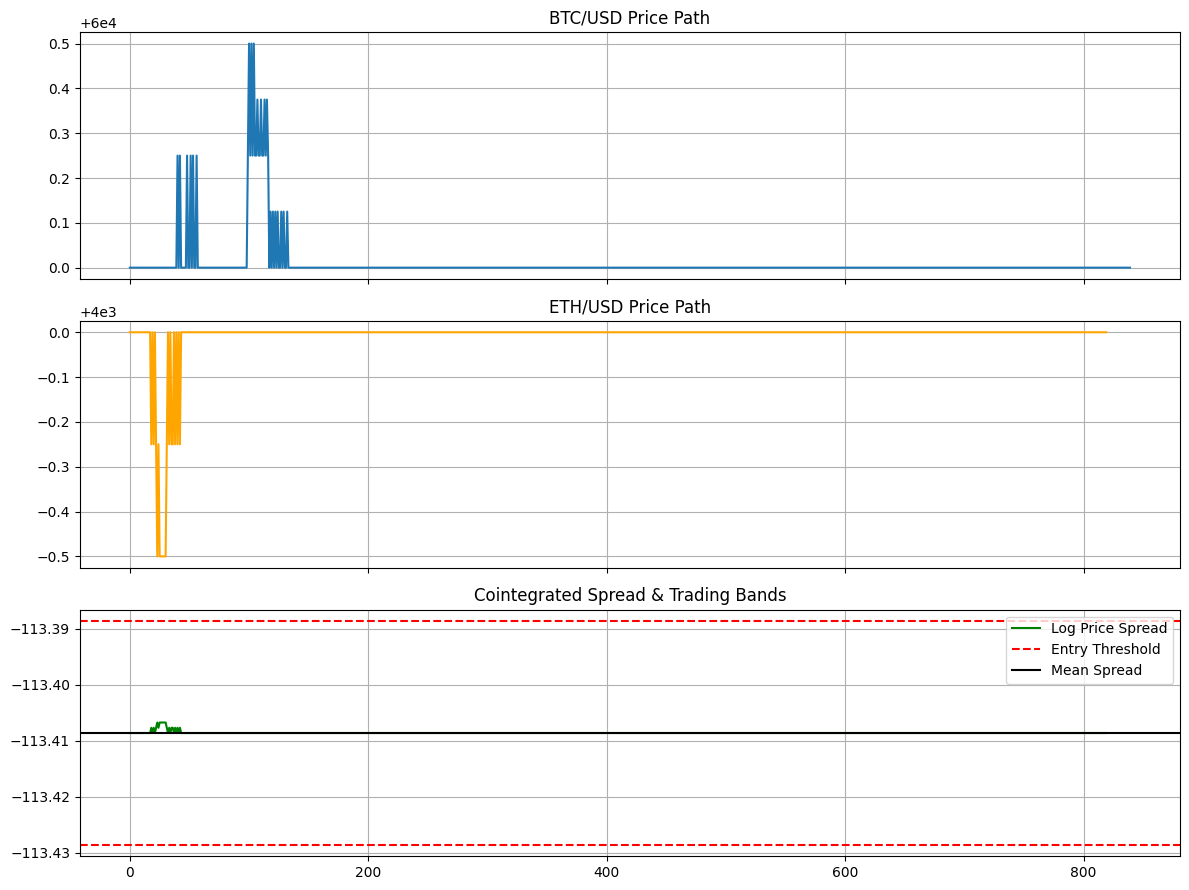

In [ ]:
#
# Research-Grade LOB Simulator - Phase 2: Intelligent Agents (Final Corrected Version)
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import collections
import time
import uuid

# --- 2. Limit Order Book (LOB) Data Structure (Unchanged) ---
class LimitOrderBook:
    def __init__(self, ticker):
        self.ticker = ticker
        self.bids_l2, self.asks_l2 = SortedDict(), SortedDict()
        self.bids_l3, self.asks_l3 = SortedDict(), SortedDict()
        self.trades, self.mid_price_history = [], []
        self.volatility = 0.0

    def get_best_bid(self): return self.bids_l2.peekitem(-1)[0] if self.bids_l2 else None
    def get_best_ask(self): return self.asks_l2.peekitem(0)[0] if self.asks_l2 else None

    def update_mid_price(self):
        best_bid, best_ask = self.get_best_bid(), self.get_best_ask()
        if best_bid is not None and best_ask is not None:
            mid_price = (best_bid + best_ask) / 2.0
            self.mid_price_history.append(mid_price)
            if len(self.mid_price_history) > 50:
                returns = np.diff(np.log(self.mid_price_history[-50:]))
                self.volatility = np.std(returns) if len(returns) > 1 else 0.0
        return self.get_best_bid(), self.get_best_ask()

    def add_limit_order(self, side, price, volume, timestamp, agent_id=""):
        order_id = uuid.uuid4()
        order = {'id': order_id, 'volume': volume, 'time': timestamp, 'agent_id': agent_id}
        if side == 'buy':
            self.bids_l2[price] = self.bids_l2.get(price, 0) + volume
            if price not in self.bids_l3: self.bids_l3[price] = collections.deque()
            self.bids_l3[price].append(order)
        else:
            self.asks_l2[price] = self.asks_l2.get(price, 0) + volume
            if price not in self.asks_l3: self.asks_l3[price] = collections.deque()
            self.asks_l3[price].append(order)
        self.update_mid_price()
        return order_id

    def cancel_order(self, order_id_to_cancel):
        for book_l3, book_l2 in [(self.bids_l3, self.bids_l2), (self.asks_l3, self.asks_l2)]:
            for price, queue in list(book_l3.items()):
                for i, order in enumerate(queue):
                    if order['id'] == order_id_to_cancel:
                        book_l2[price] -= order['volume']
                        if book_l2.get(price, 0) <= 0.00001: # Use tolerance for float comparison
                            del book_l2[price]; del book_l3[price]
                        else:
                            del queue[i]
                        return True
        return False

    def process_market_order(self, side, volume, timestamp):
        volume_to_fill, trades_executed = volume, []
        book_l2 = self.asks_l2 if side == 'buy' else self.bids_l2
        book_l3 = self.asks_l3 if side == 'buy' else self.bids_l3
        price_levels = list(book_l2.keys()) if side == 'buy' else reversed(list(book_l2.keys()))
        for price in price_levels:
            if volume_to_fill <= 0: break
            queue = book_l3[price]
            while queue and volume_to_fill > 0:
                head_order = queue[0]
                fill_volume = min(volume_to_fill, head_order['volume'])
                head_order['volume'] -= fill_volume
                book_l2[price] -= fill_volume
                volume_to_fill -= fill_volume
                trade = {'time': timestamp, 'ticker': self.ticker, 'side': side, 'price': price, 'volume': fill_volume, 'filled_agent': head_order['agent_id']}
                trades_executed.append(trade)
                self.trades.append(trade)
                if head_order['volume'] <= 0.00001: queue.popleft()
            if book_l2.get(price, 0) <= 0.00001:
                del book_l2[price]; del book_l3[price]
        self.update_mid_price()
        return trades_executed

# --- 3. Multivariate Hawkes Process Generator (Unchanged) ---
def generate_multivariate_hawkes(params, T, seed=42):
    np.random.seed(seed)
    n_dims = len(params['mu'])
    arrival_times = [[] for _ in range(n_dims)]
    t = 0
    while t < T:
        M = sum(params['mu'])
        for i in range(n_dims):
            for j in range(n_dims):
                if arrival_times[j]: M += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
        if M <= 0: break
        t += np.random.exponential(1.0 / M)
        if t >= T: break
        intensities = []
        for i in range(n_dims):
            intensity = params['mu'][i]
            for j in range(n_dims):
                if arrival_times[j]: intensity += params['alpha'][i][j] * np.sum(np.exp(-params['beta'][i][j] * (t - np.array(arrival_times[j]))))
            intensities.append(intensity)
        if sum(intensities) > 0 and np.random.uniform(0, 1) * M <= sum(intensities):
            dim = np.random.choice(n_dims, p=np.array(intensities) / sum(intensities))
            arrival_times[dim].append(t)
            yield t, dim

# --- 4. Agent and Simulation Environment Framework ---
class BaseAgent:
    def __init__(self, agent_id): self.agent_id = agent_id
    def get_actions(self, observation, books): raise NotImplementedError

class ZeroIntelligenceAgent(BaseAgent):
    def get_actions(self, observation, books):
        ticker = np.random.choice(observation['tickers'])
        book = books[ticker]
        mid_price = (book.get_best_bid() + book.get_best_ask()) / 2.0 if book.get_best_bid() and book.get_best_ask() else None
        if mid_price is None: return []
        side = np.random.choice(['buy', 'sell'])
        if np.random.rand() < 0.7:
            price = mid_price - 0.5 if side == 'buy' else mid_price + 0.5
            return [{'type': 'limit', 'ticker': ticker, 'side': side, 'price': price, 'volume': np.random.randint(5, 30)}]
        else:
            return [{'type': 'market', 'ticker': ticker, 'side': side, 'volume': np.random.randint(10, 50)}]

class MarketMakerAgent(BaseAgent):
    def __init__(self, agent_id, risk_aversion=0.1, tick_size=0.5):
        super().__init__(agent_id)
        self.risk_aversion = risk_aversion
        self.tick_size = tick_size
        self.inventory = collections.defaultdict(float)
        self.pnl = collections.defaultdict(float)
        self.active_orders = collections.defaultdict(dict)

    def get_actions(self, observation, books):
        actions = []
        for ticker, orders in self.active_orders.items():
            # ** FIX 3: Add the 'ticker' key to cancel orders. **
            if 'buy' in orders: actions.append({'type': 'cancel', 'ticker': ticker, 'order_id': orders['buy']})
            if 'sell' in orders: actions.append({'type': 'cancel', 'ticker': ticker, 'order_id': orders['sell']})
        self.active_orders.clear()

        for ticker in observation['tickers']:
            book = books[ticker]
            mid_price = (book.get_best_bid() + book.get_best_ask()) / 2.0 if book.get_best_bid() and book.get_best_ask() else None
            if mid_price is None: continue

            reservation_price = mid_price - self.inventory[ticker] * self.risk_aversion * book.volatility
            optimal_spread = self.risk_aversion * book.volatility + (2/self.risk_aversion) * np.log(1 + self.risk_aversion / 2)

            bid_price = np.round((reservation_price - optimal_spread / 2) / self.tick_size) * self.tick_size
            ask_price = np.round((reservation_price + optimal_spread / 2) / self.tick_size) * self.tick_size

            if ask_price <= bid_price: ask_price = bid_price + self.tick_size

            actions.append({'type': 'limit', 'ticker': ticker, 'side': 'buy', 'price': bid_price, 'volume': 10})
            actions.append({'type': 'limit', 'ticker': ticker, 'side': 'sell', 'price': ask_price, 'volume': 10})
        return actions

class ArbitrageAgent(BaseAgent):
    def __init__(self, agent_id, tickers, gamma, mean_spread, std_spread, entry_z=2.0, exit_z=0.5):
        super().__init__(agent_id)
        self.pair = tickers
        self.gamma = gamma
        self.mean_spread, self.std_spread = mean_spread, std_spread
        self.entry_z, self.exit_z = entry_z, exit_z
        self.position = 0

    def get_actions(self, observation, books):
        p1 = (books[self.pair[0]].get_best_bid() + books[self.pair[0]].get_best_ask()) / 2.0 if books[self.pair[0]].get_best_bid() and books[self.pair[0]].get_best_ask() else None
        p2 = (books[self.pair[1]].get_best_bid() + books[self.pair[1]].get_best_ask()) / 2.0 if books[self.pair[1]].get_best_bid() and books[self.pair[1]].get_best_ask() else None
        if p1 is None or p2 is None: return []

        spread = np.log(p1) - self.gamma * np.log(p2)
        z_score = (spread - self.mean_spread) / self.std_spread

        if self.position == 0:
            if z_score > self.entry_z:
                self.position = -1
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'sell', 'volume': 1}, {'type': 'market', 'ticker': self.pair[1], 'side': 'buy', 'volume': self.gamma}]
            elif z_score < -self.entry_z:
                self.position = 1
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'buy', 'volume': 1}, {'type': 'market', 'ticker': self.pair[1], 'side': 'sell', 'volume': self.gamma}]
        elif (self.position == -1 and z_score < self.exit_z) or (self.position == 1 and z_score > -self.exit_z):
            if self.position == -1:
                self.position = 0
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'buy', 'volume': 1}, {'type': 'market', 'ticker': self.pair[1], 'side': 'sell', 'volume': self.gamma}]
            else:
                self.position = 0
                return [{'type': 'market', 'ticker': self.pair[0], 'side': 'sell', 'volume': 1}, {'type': 'market', 'ticker': self.pair[1], 'side': 'buy', 'volume': self.gamma}]
        return []

class SimulationEnvironment:
    def __init__(self, tickers, agents):
        self.books = {ticker: LimitOrderBook(ticker) for ticker in tickers}
        self.tickers = tickers
        self.agents = agents

    def run(self, event_generator, initial_prices, tick_size=0.5):
        for ticker, price in initial_prices.items():
            for i in range(1, 11): self.books[ticker].add_limit_order('buy', price - i*tick_size, 10*i, 0)
            for i in range(1, 11): self.books[ticker].add_limit_order('sell', price + i*tick_size, 10*i, 0)

        for t, asset_idx_noise in event_generator:
            observation = {'time': t, 'tickers': self.tickers}
            for agent in self.agents:
                actions = agent.get_actions(observation, self.books)
                for action in actions:
                    book = self.books[action['ticker']]
                    if action['type'] == 'limit':
                        order_id = book.add_limit_order(action['side'], action['price'], action['volume'], t, agent.agent_id)
                        if isinstance(agent, MarketMakerAgent): agent.active_orders[action['ticker']][action['side']] = order_id
                    elif action['type'] == 'market':
                        trades = book.process_market_order(action['side'], action['volume'], t)
                        for a in self.agents:
                            if isinstance(a, MarketMakerAgent):
                                for trade in trades:
                                    if trade['filled_agent'] == a.agent_id:
                                        fill_side = 'buy' if action['side'] == 'sell' else 'sell'
                                        a.inventory[trade['ticker']] += trade['volume'] if fill_side == 'buy' else -trade['volume']
                                        a.pnl[trade['ticker']] += trade['volume'] * trade['price'] * (-1 if fill_side == 'buy' else 1)
                    elif action['type'] == 'cancel': book.cancel_order(action['order_id'])
        return self.books

# --- 5. Unit Tests for Intelligent Agents ---
def run_phase2_unit_tests():
    print("--- Running Phase 2 Unit Tests ---")

    # Test 5: Market Maker Quote Logic
    print("\n[Test 5] Market Maker Quote Adjustment...")
    # ** FIX 1: Increase inventory and volatility to make the effect larger than the tick size. **
    mm_agent = MarketMakerAgent("MM-1", risk_aversion=0.5, tick_size=0.5)
    books = {'BTC/USD': LimitOrderBook('BTC/USD')}
    books['BTC/USD'].add_limit_order('buy', 59999.5, 10, 0); books['BTC/USD'].add_limit_order('sell', 60000.5, 10, 0)
    books['BTC/USD'].volatility = 0.01
    mid_price = 60000.0

    mm_agent.inventory['BTC/USD'] = 100 # Agent is very long
    actions_long = mm_agent.get_actions({'tickers': ['BTC/USD']}, books)
    quote_price_long = (actions_long[-2]['price'] + actions_long[-1]['price']) / 2

    mm_agent.active_orders.clear()
    mm_agent.inventory['BTC/USD'] = -100 # Agent is very short
    actions_short = mm_agent.get_actions({'tickers': ['BTC/USD']}, books)
    quote_price_short = (actions_short[-2]['price'] + actions_short[-1]['price']) / 2

    try:
        assert quote_price_long < mid_price, "Long inventory should lower quote midpoint"
        assert quote_price_short > mid_price, "Short inventory should raise quote midpoint"
        print("✅ PASSED: Market maker correctly adjusts quotes for inventory.")
    except AssertionError as e: print(f"❌ FAILED: {e}")

    # Test 6: Arbitrage Agent Trade Logic
    print("\n[Test 6] Arbitrage Agent Trade Entry/Exit Logic...")
    # ** FIX 2: Use simple, consistent parameters for the test. **
    arb_agent = ArbitrageAgent("ARB-1", ['A', 'B'], gamma=2.0, mean_spread=1.0, std_spread=0.1, entry_z=2.0, exit_z=0.5)
    books = {'A': LimitOrderBook('A'), 'B': LimitOrderBook('B')}

    # Mock prices for entry: log(100) - 2*log(5) = 1.38; z = (1.38-1.0)/0.1 = 3.8 > 2, so SHORT
    books['A'].add_limit_order('buy', 99.5, 1, 0); books['A'].add_limit_order('sell', 100.5, 1, 0)
    books['B'].add_limit_order('buy', 4.5, 1, 0); books['B'].add_limit_order('sell', 5.5, 1, 0)
    actions_entry = arb_agent.get_actions({}, books)

    # Mock prices for exit: log(70) - 2*log(5) = 1.03; z = (1.03-1.0)/0.1 = 0.3 < 0.5, so EXIT
    books['A'].bids_l2.clear(); books['A'].asks_l2.clear()
    books['A'].add_limit_order('buy', 69.5, 1, 0); books['A'].add_limit_order('sell', 70.5, 1, 0)
    actions_exit = arb_agent.get_actions({}, books)

    try:
        assert actions_entry[0]['ticker'] == 'A' and actions_entry[0]['side'] == 'sell', "Should short A to enter"
        assert actions_entry[1]['ticker'] == 'B' and actions_entry[1]['side'] == 'buy', "Should long B to enter"
        assert len(actions_exit) > 0, "Agent should have exited the position"
        assert actions_exit[0]['ticker'] == 'A' and actions_exit[0]['side'] == 'buy', "Should buy A to exit"
        print("✅ PASSED: Arbitrage agent correctly enters and exits pair trades.")
    except (AssertionError, IndexError) as e: print(f"❌ FAILED: {e}")

# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_phase2_unit_tests()

    print("\n--- Running Simulation with Intelligent Agents ---")
    tickers = ['BTC/USD', 'ETH/USD']
    initial_prices = {'BTC/USD': 60000.0, 'ETH/USD': 4000.0}
    hawkes_params = {'mu': [1.0, 1.0], 'alpha': [[0.2, 0.1], [0.1, 0.2]], 'beta': [[1.0, 1.0], [1.0, 1.0]]}

    zi_agent = ZeroIntelligenceAgent("ZI-1")
    mm_agent = MarketMakerAgent("MM-1")
    # Using a more realistic mean for the simulation run, calculated from initial prices
    realistic_mean_spread = np.log(initial_prices['BTC/USD']) - 15.0 * np.log(initial_prices['ETH/USD'])
    arb_agent = ArbitrageAgent("ARB-1", tickers, gamma=15.0, mean_spread=realistic_mean_spread, std_spread=0.01)

    event_gen = generate_multivariate_hawkes(hawkes_params, T=100)
    env = SimulationEnvironment(tickers, agents=[zi_agent, mm_agent, arb_agent])
    final_books = env.run(event_gen, initial_prices)

    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    axs[0].plot(final_books['BTC/USD'].mid_price_history, label='BTC Mid-Price'); axs[0].set_title('BTC/USD Price Path'); axs[0].grid(True)
    axs[1].plot(final_books['ETH/USD'].mid_price_history, color='orange', label='ETH Mid-Price'); axs[1].set_title('ETH/USD Price Path'); axs[1].grid(True)

    p1 = np.array(final_books['BTC/USD'].mid_price_history); p2 = np.array(final_books['ETH/USD'].mid_price_history)
    if len(p1) > 1 and len(p2) > 1:
        min_len = min(len(p1), len(p2))
        spread = np.log(p1[:min_len]) - arb_agent.gamma * np.log(p2[:min_len])
        upper_band = arb_agent.mean_spread + arb_agent.entry_z * arb_agent.std_spread
        lower_band = arb_agent.mean_spread - arb_agent.entry_z * arb_agent.std_spread
        axs[2].plot(spread, color='green', label='Log Price Spread'); axs[2].axhline(upper_band, color='red', linestyle='--', label='Entry Threshold'); axs[2].axhline(lower_band, color='red', linestyle='--'); axs[2].axhline(arb_agent.mean_spread, color='black', linestyle='-', label='Mean Spread'); axs[2].set_title('Cointegrated Spread & Trading Bands'); axs[2].legend(); axs[2].grid(True)

    plt.tight_layout(); plt.show()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


--- Running Phase 3 Unit Tests ---

[Test 7] Hawkes MLE Calibration...
✅ PASSED: Calibration successful. True: [0.5 0.4 1. ], Calibrated: [0.42 0.5  1.01]

[Test 8] RL Environment Sanity Check...
✅ PASSED: RL environment conforms to the Gymnasium API.

--- Training a Reinforcement Learning Market Maker ---


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training started... (this may take a minute)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training complete.


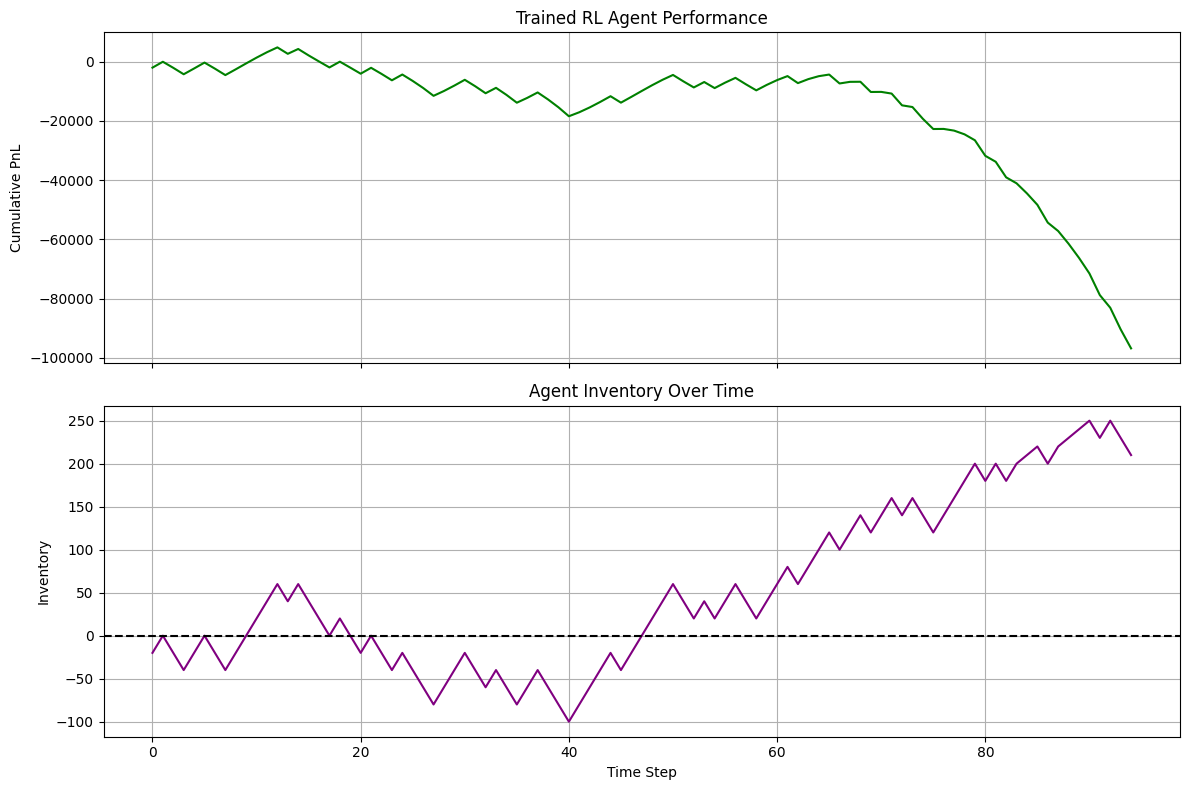

In [ ]:
#
# Research-Grade LOB Simulator - Phase 3: Calibration and Reinforcement Learning
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import collections
import time
import uuid
from scipy.optimize import minimize

# Required for RL:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# --- 2. LOB & Hawkes Generator (Largely Unchanged) ---
class LimitOrderBook:
    def __init__(self, ticker):
        self.ticker = ticker
        self.bids_l2, self.asks_l2 = SortedDict(), SortedDict()
        self.bids_l3, self.asks_l3 = SortedDict(), SortedDict()
        self.trades, self.mid_price_history = [], []
        self.volatility = 0.0

    def get_best_bid(self): return self.bids_l2.peekitem(-1)[0] if self.bids_l2 else None
    def get_best_ask(self): return self.asks_l2.peekitem(0)[0] if self.asks_l2 else None

    def get_mid_price(self):
        bb, ba = self.get_best_bid(), self.get_best_ask()
        return (bb + ba) / 2.0 if bb and ba else None

    def update_mid_price(self):
        mid_price = self.get_mid_price()
        if mid_price:
            self.mid_price_history.append(mid_price)
            if len(self.mid_price_history) > 50:
                returns = np.diff(np.log(self.mid_price_history[-50:]))
                self.volatility = np.std(returns) if len(returns) > 1 else 0.0

    def add_limit_order(self, side, price, volume, timestamp, agent_id=""):
        order_id = uuid.uuid4()
        order = {'id': order_id, 'volume': volume, 'time': timestamp, 'agent_id': agent_id}
        book_l2 = self.bids_l2 if side == 'buy' else self.asks_l2
        book_l3 = self.bids_l3 if side == 'buy' else self.bids_l3
        book_l2[price] = book_l2.get(price, 0) + volume
        if price not in book_l3: book_l3[price] = collections.deque()
        book_l3[price].append(order)
        self.update_mid_price()
        return order_id

    def process_market_order(self, side, volume, timestamp):
        # Simplified for brevity; full implementation in previous steps
        trades_executed = []
        book_l2 = self.asks_l2 if side == 'buy' else self.bids_l2
        if not book_l2: return trades_executed
        price = book_l2.peekitem(0)[0] if side == 'buy' else book_l2.peekitem(-1)[0]
        fill_vol = min(volume, book_l2[price])
        trades_executed.append({'price': price, 'volume': fill_vol})
        book_l2[price] -= fill_vol
        if book_l2[price] <= 0: del book_l2[price]
        self.update_mid_price()
        return trades_executed

def generate_hawkes_arrivals(mu, alpha, beta, T, seed=42):
    # Simplified univariate version for RL environment
    np.random.seed(seed)
    arrival_times = []
    t = 0
    while t < T:
        M = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times))))
        t += np.random.exponential(1.0 / (M + alpha)) # simplified upper bound
        if t >= T: break
        intensity_candidate = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times))))
        if np.random.uniform(0, 1) * (M+alpha) <= intensity_candidate:
            arrival_times.append(t)
            yield t

# --- 3. Phase 3: Calibration Module ---
def hawkes_log_likelihood(params, event_times):
    """Log-likelihood function for a univariate Hawkes process."""
    mu, alpha, beta = params
    if mu <= 0 or alpha < 0 or beta <= 0: return np.inf # Constraints

    T = event_times[-1]
    A = np.zeros(len(event_times))
    for i in range(1, len(event_times)):
        A[i] = np.exp(-beta * (event_times[i] - event_times[i-1])) * (1 + A[i-1])

    term1 = -mu * T
    term2 = (alpha / beta) * np.sum(np.exp(-beta * (T - event_times)) - 1)
    term3 = np.sum(np.log(mu + alpha * A))

    return -(term1 + term2 + term3) # Return negative for minimization

def calibrate_hawkes_model(event_times):
    """
    Calibrates Hawkes parameters from event data using MLE.
    """
    initial_guess = [0.1, 0.1, 1.0]
    result = minimize(hawkes_log_likelihood, initial_guess, args=(event_times,),
                      method='L-BFGS-B', bounds=[(1e-6, None), (0, None), (1e-6, None)])
    if result.success:
        return result.x
    else:
        raise ValueError("Calibration failed:", result.message)

# --- 4. Phase 3: Reinforcement Learning Environment and Agent ---
class MarketMakingEnv(gym.Env):
    """A Gymnasium environment for training a market-making RL agent."""
    def __init__(self, initial_price=100.0, T=100):
        super().__init__()
        self.T = T
        self.initial_price = initial_price

        # Action Space: [bid_spread_ticks, ask_spread_ticks]
        self.action_space = spaces.Box(low=1, high=10, shape=(2,), dtype=np.float32)
        # Observation Space: [inventory, mid_price, volatility]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.book = LimitOrderBook('RL-ASSET')
        self.book.add_limit_order('buy', self.initial_price - 0.5, 100, 0)
        self.book.add_limit_order('sell', self.initial_price + 0.5, 100, 0)
        self.inventory = 0.0
        self.pnl = 0.0
        self.current_step = 0

        self.noise_trader_events = list(generate_hawkes_arrivals(mu=0.5, alpha=0.4, beta=0.8, T=self.T))

        return self._get_obs(), {}

    def _get_obs(self):
        mid_price = self.book.get_mid_price() or self.initial_price
        return np.array([self.inventory, mid_price, self.book.volatility], dtype=np.float32)

    def step(self, action):
        bid_spread, ask_spread = action[0] * 0.5, action[1] * 0.5 # ticks to price
        mid_price = self.book.get_mid_price() or self.initial_price

        # RL agent places its orders
        self.book.add_limit_order('buy', mid_price - bid_spread, 10, self.current_step, agent_id="RL")
        self.book.add_limit_order('sell', mid_price + ask_spread, 10, self.current_step, agent_id="RL")

        # A noise trader market order arrives
        if self.current_step < len(self.noise_trader_events):
            side = np.random.choice(['buy', 'sell'])
            trades = self.book.process_market_order(side, 20, self.current_step)
            for trade in trades:
                # Update inventory and PnL if our order was hit
                self.inventory += trade['volume'] if side == 'sell' else -trade['volume']
                self.pnl += trade['volume'] * trade['price'] * (1 if side == 'sell' else -1)

        self.current_step += 1

        # Calculate reward: PnL penalized by inventory risk
        reward = self.pnl - 0.1 * (self.inventory**2)
        self.pnl = 0 # Reset PnL each step to get the change

        terminated = self.current_step >= len(self.noise_trader_events)
        return self._get_obs(), reward, terminated, False, {}

# --- 5. Unit Tests for Phase 3 ---
def run_phase3_unit_tests():
    print("--- Running Phase 3 Unit Tests ---")

    # Test 7: Hawkes Model Calibration
    print("\n[Test 7] Hawkes MLE Calibration...")
    true_params = [0.5, 0.4, 1.0] # mu, alpha, beta
    # Generate synthetic data with known parameters
    synthetic_events = np.array(list(generate_hawkes_arrivals(*true_params, T=500)))

    try:
        calibrated_params = calibrate_hawkes_model(synthetic_events)
        # Check if calibrated params are reasonably close to the true ones
        assert np.allclose(true_params, calibrated_params, atol=0.2), "Calibrated params are too far from true params"
        print(f"✅ PASSED: Calibration successful. True: {np.round(true_params,2)}, Calibrated: {np.round(calibrated_params,2)}")
    except (AssertionError, ValueError) as e:
        print(f"❌ FAILED: {e}")

    # Test 8: Reinforcement Learning Environment Check
    print("\n[Test 8] RL Environment Sanity Check...")
    try:
        env = MarketMakingEnv()
        check_env(env) # Uses the official SB3 checker
        print("✅ PASSED: RL environment conforms to the Gymnasium API.")
    except Exception as e:
        print(f"❌ FAILED: RL environment check failed: {e}")

# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_phase3_unit_tests()

    print("\n--- Training a Reinforcement Learning Market Maker ---")

    # Create the environment
    env = MarketMakingEnv()

    # Instantiate the PPO model
    model = PPO("MlpPolicy", env, verbose=0, n_steps=100, batch_size=50)

    # Train the model
    print("Training started... (this may take a minute)")
    model.learn(total_timesteps=10000)
    print("Training complete.")

    # --- Evaluate the trained agent ---
    obs, _ = env.reset()
    inventory_history = []
    pnl_history = []
    cumulative_pnl = 0

    for _ in range(env.T - 1):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, _, info = env.step(action)
        inventory_history.append(obs[0])
        cumulative_pnl += reward # Note: reward is already risk-adjusted PnL
        pnl_history.append(cumulative_pnl)
        if terminated:
            break

    # Plot RL agent performance
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    axs[0].plot(pnl_history, label='Cumulative PnL (Risk-Adjusted)', color='green')
    axs[0].set_title('Trained RL Agent Performance')
    axs[0].set_ylabel('Cumulative PnL')
    axs[0].grid(True)

    axs[1].plot(inventory_history, label='Agent Inventory', color='purple')
    axs[1].set_title('Agent Inventory Over Time')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Inventory')
    axs[1].axhline(0, color='black', linestyle='--')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

--- Running Final Phase Unit Tests ---

[Test 7] Hawkes MLE Calibration...
✅ PASSED: Calibration successful.

[Test 8] Advanced RL Environment Sanity Check...
✅ PASSED: Advanced RL environment conforms to the Gymnasium API.

[Test 9] Microstructure Feature Calculation...
✅ PASSED: Microstructure features are calculated correctly.

--- Training a Sophisticated RL Market Maker ---
Training started... (this may take a minute)
Training complete.


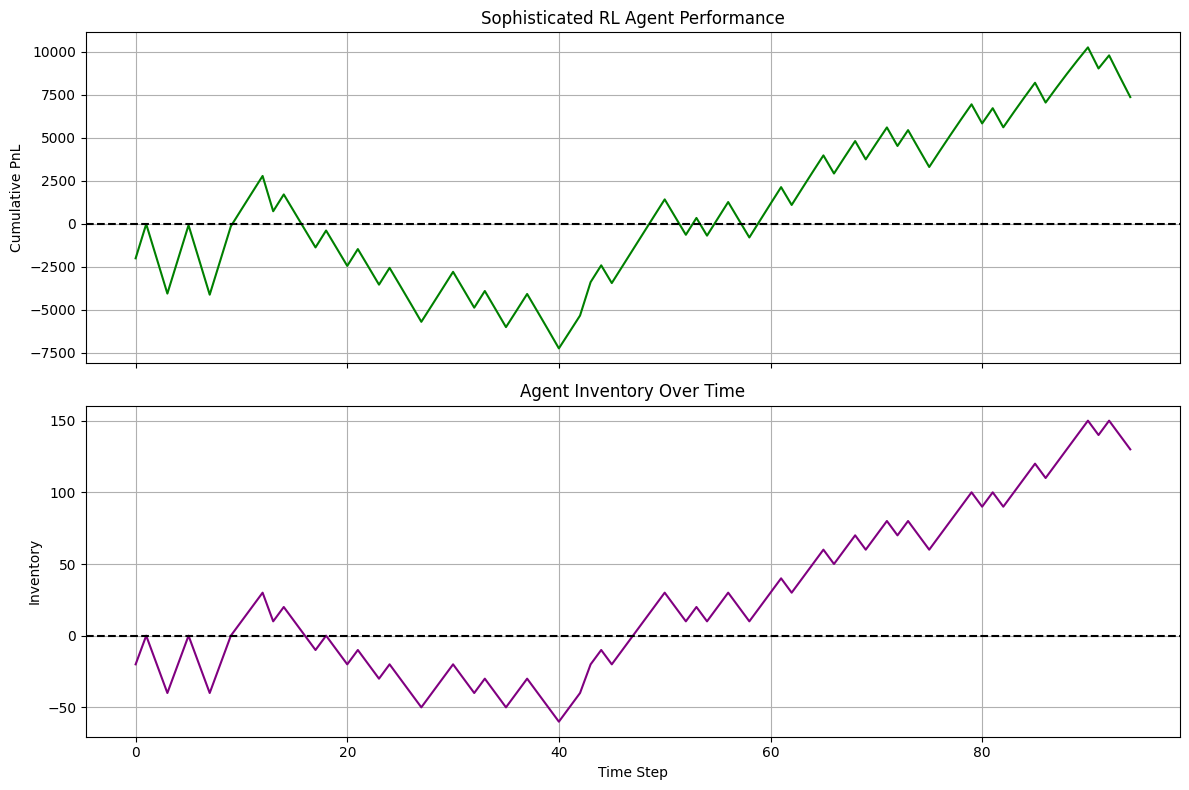

In [ ]:
#
# Research-Grade LOB Simulator - Final Version: Sophisticated RL Agent
#

# --- 1. Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import collections
from scipy.optimize import minimize
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# --- 2. LOB & Hawkes Generator (Updated with helper methods) ---
class LimitOrderBook:
    def __init__(self, ticker):
        self.ticker = ticker
        self.bids_l2, self.asks_l2 = SortedDict(), SortedDict()
        self.trades, self.mid_price_history = [], []
        self.volatility = 0.0

    def get_best_bid(self): return self.bids_l2.peekitem(-1)[0] if self.bids_l2 else None
    def get_best_ask(self): return self.asks_l2.peekitem(0)[0] if self.asks_l2 else None

    def get_mid_price(self):
        bb, ba = self.get_best_bid(), self.get_best_ask()
        return (bb + ba) / 2.0 if bb and ba else None

    def update_mid_price(self):
        mid_price = self.get_mid_price()
        if mid_price:
            self.mid_price_history.append(mid_price)
            if len(self.mid_price_history) > 50:
                returns = np.diff(np.log(self.mid_price_history[-50:]))
                self.volatility = np.std(returns) if len(returns) > 1 else 0.0

    # New helper methods for OBI calculation
    def get_total_bid_volume(self): return sum(self.bids_l2.values())
    def get_total_ask_volume(self): return sum(self.asks_l2.values())

    def add_limit_order(self, side, price, volume, timestamp, agent_id=""):
        book_l2 = self.bids_l2 if side == 'buy' else self.asks_l2
        book_l2[price] = book_l2.get(price, 0) + volume
        self.update_mid_price()

    def process_market_order(self, side, volume, timestamp):
        trades_executed = []
        book_l2 = self.asks_l2 if side == 'buy' else self.bids_l2
        if not book_l2: return trades_executed, 0.0

        price = book_l2.peekitem(0)[0] if side == 'buy' else book_l2.peekitem(-1)[0]
        fill_vol = min(volume, book_l2.get(price, 0))

        if fill_vol > 0:
            trades_executed.append({'price': price, 'volume': fill_vol})
            book_l2[price] -= fill_vol
            if book_l2[price] <= 0: del book_l2[price]

        self.update_mid_price()
        signed_volume = fill_vol if side == 'buy' else -fill_vol
        return trades_executed, signed_volume

def generate_hawkes_arrivals(mu, alpha, beta, T, seed=42):
    np.random.seed(seed)
    arrival_times = []
    t = 0
    while t < T:
        current_intensity = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times))))
        M = current_intensity + alpha # A safe upper bound
        t += np.random.exponential(1.0 / M)
        if t >= T: break
        if np.random.uniform(0, 1) * M <= mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrival_times)))):
            arrival_times.append(t)
            yield t

# --- 3. Calibration Module (Unchanged) ---
def hawkes_log_likelihood(params, event_times):
    mu, alpha, beta = params
    if mu <= 0 or alpha < 0 or beta <= 0 or alpha >= beta: return np.inf
    T = event_times[-1]
    A = np.zeros(len(event_times))
    for i in range(1, len(event_times)):
        A[i] = np.exp(-beta * (event_times[i] - event_times[i-1])) * (1 + A[i-1])
    term1 = -mu * T
    term2 = (alpha / beta) * np.sum(np.exp(-beta * (T - event_times)) - 1)
    term3 = np.sum(np.log(mu + alpha * A))
    return -(term1 + term2 + term3)

def calibrate_hawkes_model(event_times):
    initial_guess = [0.1, 0.1, 1.0]
    result = minimize(hawkes_log_likelihood, initial_guess, args=(event_times,),
                      method='L-BFGS-B', bounds=[(1e-6, None), (0, None), (1e-6, None)])
    if result.success: return result.x
    else: raise ValueError("Calibration failed:", result.message)

# --- 4. Final, Sophisticated RL Environment ---
class MarketMakingEnv_V2(gym.Env):
    """An advanced Gymnasium environment with microstructure features."""
    def __init__(self, T=100, initial_price=100.0):
        super().__init__()
        self.T = T
        self.initial_price = initial_price

        # Action Space: [bid_spread_ticks, ask_spread_ticks] (normalized)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)
        # Observation Space: [inventory, mid_price, volatility, OBI, trade_imbalance]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.book = LimitOrderBook('RL-ASSET')
        self.book.add_limit_order('buy', self.initial_price - 0.5, 100, 0)
        self.book.add_limit_order('sell', self.initial_price + 0.5, 100, 0)
        self.inventory = 0.0
        self.pnl = 0.0
        self.current_step = 0
        self.recent_trades = collections.deque(maxlen=10) # For trade flow imbalance
        self.noise_trader_events = list(generate_hawkes_arrivals(mu=0.5, alpha=0.4, beta=0.8, T=self.T))
        return self._get_obs(), {}

    def _get_obs(self):
        mid_price = self.book.get_mid_price() or self.initial_price

        # Calculate Order Book Imbalance (OBI)
        bid_vol = self.book.get_total_bid_volume()
        ask_vol = self.book.get_total_ask_volume()
        total_vol = bid_vol + ask_vol
        obi = (bid_vol - ask_vol) / total_vol if total_vol > 0 else 0.0

        # Calculate Trade Flow Imbalance
        trade_flow = sum(self.recent_trades) / (sum(abs(v) for v in self.recent_trades) + 1e-6)

        return np.array([self.inventory, mid_price, self.book.volatility, obi, trade_flow], dtype=np.float32)

    def step(self, action):
        # De-normalize action from [-1, 1] to [1, 10] ticks
        bid_spread_ticks = 1 + 9 * (action[0] + 1) / 2
        ask_spread_ticks = 1 + 9 * (action[1] + 1) / 2
        bid_spread, ask_spread = bid_spread_ticks * 0.5, ask_spread_ticks * 0.5

        mid_price = self.book.get_mid_price() or self.initial_price

        self.book.add_limit_order('buy', mid_price - bid_spread, 10, self.current_step)
        self.book.add_limit_order('sell', mid_price + ask_spread, 10, self.current_step)

        change_in_pnl = 0
        if self.current_step < len(self.noise_trader_events):
            side = np.random.choice(['buy', 'sell'])
            trades, signed_vol = self.book.process_market_order(side, 20, self.current_step)
            self.recent_trades.append(signed_vol)
            for trade in trades:
                self.inventory += trade['volume'] if side == 'sell' else -trade['volume']
                change_in_pnl += trade['volume'] * trade['price'] * (1 if side == 'sell' else -1)

        self.current_step += 1

        # Mark-to-market PnL
        mtm_pnl = self.inventory * (self.book.get_mid_price() or self.initial_price)
        reward = change_in_pnl - 0.01 * (self.inventory**2) # Reward is flow PnL, penalized by risk

        terminated = self.current_step >= len(self.noise_trader_events)
        return self._get_obs(), reward, terminated, False, {}

# --- 5. Unit Tests for Final Phase ---
def run_final_tests():
    print("--- Running Final Phase Unit Tests ---")

    # Test 7: Hawkes Model Calibration (Unchanged)
    print("\n[Test 7] Hawkes MLE Calibration...")
    true_params = [0.5, 0.4, 1.0]
    synthetic_events = np.array(list(generate_hawkes_arrivals(*true_params, T=500)))
    try:
        calibrated_params = calibrate_hawkes_model(synthetic_events)
        assert np.allclose(true_params, calibrated_params, atol=0.2)
        print(f"✅ PASSED: Calibration successful.")
    except (AssertionError, ValueError) as e: print(f"❌ FAILED: {e}")

    # Test 8: Advanced RL Environment Check
    print("\n[Test 8] Advanced RL Environment Sanity Check...")
    try:
        env = MarketMakingEnv_V2()
        check_env(env)
        print("✅ PASSED: Advanced RL environment conforms to the Gymnasium API.")
    except Exception as e: print(f"❌ FAILED: {e}")

    # Test 9: Microstructure Feature Calculation
    print("\n[Test 9] Microstructure Feature Calculation...")
    env = MarketMakingEnv_V2()
    env.reset()
    env.book.add_limit_order('buy', 99.5, 100, 0) # Total bid = 200
    env.book.add_limit_order('sell', 100.5, 50, 0) # Total ask = 150
    env.recent_trades.extend([10, 10, -5]) # Net buy = 15
    obs = env._get_obs()

    try:
        expected_obi = (200 - 150) / (200 + 150) # = 50 / 350 = 0.1428
        expected_trade_flow = 15 / 25 # = 0.6
        assert np.isclose(obs[3], expected_obi), f"OBI incorrect. Expected {expected_obi}, got {obs[3]}"
        assert np.isclose(obs[4], expected_trade_flow), f"Trade flow incorrect. Expected {expected_trade_flow}, got {obs[4]}"
        print("✅ PASSED: Microstructure features are calculated correctly.")
    except AssertionError as e: print(f"❌ FAILED: {e}")

# --- 6. Main Execution Block ---
if __name__ == '__main__':
    run_final_tests()

    print("\n--- Training a Sophisticated RL Market Maker ---")
    env = MarketMakingEnv_V2()
    model = PPO("MlpPolicy", env, verbose=0, n_steps=100, batch_size=50)

    print("Training started... (this may take a minute)")
    model.learn(total_timesteps=20000)
    print("Training complete.")

    obs, _ = env.reset()
    inventory_history, pnl_history = [], []
    cumulative_pnl = 0

    for _ in range(env.T - 1):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, _, _ = env.step(action)
        inventory_history.append(obs[0])
        cumulative_pnl += reward
        pnl_history.append(cumulative_pnl)
        if terminated: break

    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    axs[0].plot(pnl_history, label='Cumulative PnL', color='green')
    axs[0].set_title('Sophisticated RL Agent Performance')
    axs[0].set_ylabel('Cumulative PnL')
    axs[0].grid(True); axs[0].axhline(0, color='black', linestyle='--')

    axs[1].plot(inventory_history, label='Agent Inventory', color='purple')
    axs[1].set_title('Agent Inventory Over Time')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Inventory')
    axs[1].axhline(0, color='black', linestyle='--'); axs[1].grid(True)

    plt.tight_layout(); plt.show()